# Loading wikipedia bios

## loading raw identities

In [45]:
import pandas as pd
from ast import literal_eval


df = pd.read_csv('FinalDataFrame5.csv')
df.identities = df.identities.apply(literal_eval)
bios = list(df['identities'])

bios[:5]

[['rapper'],
 ['minister', 'Bible scholar', 'author'],
 ['astrophysicist'],
 ['snooker', 'billiards player'],
 ['Welsh sports journalist']]

In [46]:
len(bios)

985429

In [ ]:
pd.set_option("max_colwidth", None)
df.iloc[1:2]

In [ ]:
# The rest is similar to twitter bios approach

# Loading twitter bios

## load all raw data

In [ ]:
import pickle
with open('/user/smadani/navid/data/pis2020.pkl', 'rb') as f:
    bios = pickle.load(f)
    

# PI frequency and top PIs

In [ ]:
from collections import Counter
cntr = Counter()

for bio in bios:
    cntr.update(bio)

print(len(bios))

In [ ]:
import numpy as np

freqs = list(cntr.values())
print(f"percentile freq: {np.percentile(freqs, 90)} mean freq: {np.mean(freqs)}")

In [ ]:
most_frequent_pis = {k:v for k,v in cntr.items() if v > 10}
len(most_frequent_pis)

In [ ]:
import pandas as pd

df = pd.DataFrame({'pi': list(most_frequent_pis.keys()), 'cnt': list(most_frequent_pis.values())})
df = df.sort_values(by=['cnt'], ascending=False)

In [ ]:
df.to_csv('wiki_most_frequent_pis.csv', index=False, header=True)

In [ ]:
!head twitter_most_frequent_pis.csv

### most frequent neighbors

In [ ]:
from tqdm import tqdm
neighbor_cnt = {}

for bio in tqdm(bios):
    for pi in bio:
        if pi in most_frequent_pis:
            if pi not in neighbor_cnt:
                neighbor_cnt[pi] = Counter()
                
            rest = [b for b in bio if b!=pi and b in most_frequent_pis]
            neighbor_cnt[pi].update(rest)

print(len(neighbor_cnt))            

#post processing and pruning empty adjacencies

for pi, adj in neighbor_cnt.copy().items():
    if len(adj) < 2:
        neighbor_cnt.pop(pi)
    
print(f"size after pruning: {len(neighbor_cnt)}")        

### calculating tf-idf

In [ ]:
for pi, neighs in tqdm(neighbor_cnt.items()):
    for phrase in neighs.keys():
        neighs[phrase] /= most_frequent_pis[phrase]
        

### calculating using bi-partite method

In [ ]:
from scipy import sparse, io

pi_idx = {}
for pi in most_frequent_pis:
    pi_idx[pi] = len(pi_idx)

#creating bipartite matrix
usr_pi = []

for bio in bios:
    cur_usr_pis = []
    for pi in bio:
        if pi in most_frequent_pis:
            cur_usr_pis.append(pi_idx[pi])
    if len(cur_usr_pis) < 2:
        continue
    usr_pi.append(cur_usr_pis)
    

print(f"original users: {len(bios)}")
print(f"no of users after pruning: {len(usr_pi)}")


In [ ]:
usrs = []
pis = []
scores = []

for uid, pis in enumerate(usr_pi):
    for pi in pis:
        usrs.append(uid)
        pis.append(pi)
        scores.append(1)

In [ ]:
%% time

BP_MATRIX_FILENAME = "./bipartite_pi.mtx"
output_matrix = sparse.coo_matrix((scores, (usrs, pis)))
io.mmwrite(BP_MATRIX_FILENAME, output_matrix)

In [ ]:
!du -hs ./bipartite_pi.mtx

In [ ]:
from scipy import io

io.mmread(BP_MATRIX_FILENAME, output_matrix)

In [ ]:
scores

In [ ]:
!rm ./bipartite_pi.mtx.gz
!gzip ./bipartite_pi.mtx
!ls

In [ ]:
import sys

sys.path.append("../bipartite-pairs/python-scoring/")
import score_data

BP_SCORING_OUTPUT = './bipartite_output.csv.gz'
score_data.score_only(
    BP_MATRIX_FILENAME+".gz",
    ['weighted_corr_exp'],
    BP_SCORING_OUTPUT,
)

In [ ]:
!zcat ./bipartite_output.csv.gz

In [ ]:
import pandas as pd

BP_SCORING_OUTPUT = './bipartite_output.csv.gz'
df = pd.read_csv(BP_SCORING_OUTPUT)
df.head()

In [ ]:
# recreate the neighboring dictionary



### save 

In [ ]:
import pandas as pd

pis = []
positives = []
negatives = []

for pi, cntr in tqdm(neighbor_cnt.items()):
    cur_neg = [x for x in most_frequent_pis if x not in neighbor_cnt[pi]]
    if len(cur_neg) > 20:
        cur_neg = list(np.random.choice(cur_neg, size=20, replace=False))
    cur_pos = [x[0] for x in neighbor_cnt[pi].most_common(5)]
    if len(cur_neg) < 4 or len(neighbor_cnt[pi])<2:
        print(f"PASSING PI: {pi}")
        continue
    positives.append(cur_pos)
    pis.append(pi)
    negatives.append(cur_neg)
                 
print(f"saving {len(pis)} pis")
df = pd.DataFrame({'pis': pis, 'positives': positives, 'negatives': negatives})
df.to_csv('twitter_pi_with_neighbors_tfidf.csv', index=False, header=True)

In [ ]:
!wc -l wiki_pi_with_neighbors_standard.csv

In [ ]:
!head wiki_pi_with_neighbors_standard.csv

## create train and test dataset

In [ ]:
from sklearn.model_selection import train_test_split

lower_bios = []
for bio in bios:
    lower_bio = []
    for pi in bio:
        lower_bio.append(pi.lower())
    lower_bios.append(lower_bio)
    
train, test = train_test_split(lower_bios, test_size=0.2, shuffle=True)
print(len(train), len(test))



In [ ]:
import pickle

dataset = 'twitter'

with open(f'./data/{dataset}_test_bios.pkl', 'wb') as f:
    pickle.dump(test, f)
    
with open(f'./data/{dataset}_train_bios.pkl', 'wb') as f:
    pickle.dump(train, f)

In [ ]:
import pickle

dataset = 'twitter'

with open(f'./data/{dataset}_test_bios.pkl', 'rb') as f:
    test = pickle.load(f)
    
test[:5]

# Cleaning data

## phrase cleaning

In [79]:
import pickle

dataset = 'twitter'
# min_freq = 3 if dataset == 'wiki' else 100
min_freq = 500

print(min_freq)
with open(f'./data/{dataset}_train_bios.pkl', 'rb') as f:
    bios = pickle.load(f)

500


In [80]:
# build a vocabulary of phrases
from tqdm import tqdm_notebook as tqdm
from collections import Counter

pi_cnt = Counter()
for bio in tqdm(bios):
    pi_cnt.update(bio)

len(pi_cnt)

/scratch/12791954/ipykernel_13862/308708586.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for bio in tqdm(bios):


  0%|          | 0/12367897 [00:00<?, ?it/s]

7860996

In [ ]:
pi_cnt.most_common(10)

In [ ]:
pi_cnt.most_common(len(pi_cnt))[-5:]

## cleaning each bio

In [81]:
from tqdm import tqdm

# phrases of lenght at least m
# profiles with at least k phrases
# pis that's been repeated at least m times in dataset

def clean_pis(all_pis):
    result = []
    for pis in tqdm(all_pis):
        current_pi = set()
        for pi in pis:
            if len(pi) >= 2 and pi_cnt[pi] >= min_freq:
                current_pi.add(pi)
        if len(current_pi) > 1:
            result.append(list(current_pi))
            
    return result
            
cleaned_bios = clean_pis(bios)
print(len(cleaned_bios), len(bios))

100%|██████████| 12367897/12367897 [00:23<00:00, 531308.92it/s]

2753951 12367897


## saving cleaned dataset

In [82]:
with open(f'./data/{dataset}_cleaned_train_bios_{min_freq}.pkl', 'wb') as f:
    pickle.dump(cleaned_bios, f)

# Masked Language Modeling

## loading dataset

In [83]:
import pickle
import numpy as np

dataset = 'twitter'
freq = 100
    
with open(f'./data/{dataset}_cleaned_train_bios_{freq}.pkl', 'rb') as f:
    bios = pickle.load(f)
    
pi_set = set()
for bio in bios:
    pi_set.update(bio)
pi_set = list(pi_set)
    
len(bios), len(pi_set)

(2753951, 4750)


## cleaning dataset for full bio

In [84]:
from tqdm import tqdm
import re

## remove url and email addresses + social media links
cleaned_bios = []

for description in tqdm(bios):
    d = re.sub(r'\w+@\w+\.\w+', '', description.lower()).strip()
    d = re.sub(r'(on )?(snapchat|snap|ig|insta|instagram|email|phone): +[A-Za-z0-9_@.-]+', " ", d).strip()
    d = re.sub(r'http\S+', '', d).strip()
    d = d.replace("&emsp;", "").replace("&nbsp;", "")
    d = re.sub(r"\s+", " ", d).strip()
    if len(d) > 5:
        cleaned_bios.append(d)

len(cleaned_bios), cleaned_bios[:10]

  0%|          | 0/2753951 [00:00<?, ?it/s]


AttributeError: 'list' object has no attribute 'lower'

## save train and test datasets

### convert to pytorch dataset

In [14]:

from datasets import Dataset
import pandas as pd

train_df = pd.DataFrame([{'bios': ", ".join(t)} for t in bios])
train_dataset = Dataset.from_pandas(train_df)



In [15]:
!rm -rf ./data/twitter_hf_dataset

In [16]:
from datasets import DatasetDict

dataset_name = 'twitter'

train_dataset.save_to_disk(f'./data/{dataset_name}_hf_dataset')

In [18]:
!du -hs  ./data/twitter_hf_dataset/

109M	./data/twitter_hf_dataset/


## load train and test

In [19]:
from datasets import DatasetDict, Dataset

dataset_name = 'twitter'
dataset = Dataset.load_from_disk(f'./data/{dataset_name}_hf_dataset')

dataset

Dataset({
    features: ['bios'],
    num_rows: 3534903
})

## data preprocessing

### load model and tokenizers

In [21]:
from transformers import AutoModelForMaskedLM
from transformers import AutoTokenizer


# model_checkpoint = "bert-base-uncased"
model_checkpoint = "bert-large-uncased"
model = AutoModelForMaskedLM.from_pretrained(model_checkpoint)
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

Some weights of the model checkpoint at bert-large-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


### test if model

In [70]:
import torch


text = "This is a great [MASK]."


inputs = tokenizer(text, return_tensors="pt")
token_logits = model(**inputs).logits
print(token_logits.shape)
# Find the location of [MASK] and extract its logits
mask_token_index = torch.where(inputs["input_ids"] == tokenizer.mask_token_id)[1]
print(mask_token_index)
mask_token_logits = token_logits[0, mask_token_index, :]
# Pick the [MASK] candidates with the highest logits
top_5_tokens = torch.topk(mask_token_logits, 5, dim=1).indices[0].tolist()

for token in top_5_tokens:
    print(f"'>>> {text.replace(tokenizer.mask_token, tokenizer.decode([token]))}'")

torch.Size([1, 8, 30522])
tensor([5])
'>>> This is a great idea.'
'>>> This is a great day.'
'>>> This is a great place.'
'>>> This is a great time.'
'>>> This is a great thing.'


In [59]:
from transformers import AutoModelForMaskedLM
from transformers import AutoTokenizer
import torch

device = 'cpu'

config = BertConfig.from_pretrained("bert-base-uncased", output_hidden_states=True)
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
bert_model = AutoModelForMaskedLM.from_pretrained("bert-base-uncased", config=config)
bert_model = bert_model.to(device)
bert_model.eval()

bert_ft_twitter_model = AutoModelForMaskedLM.from_pretrained("./models/bert-ft-mlm-twitter/checkpoint-24992/")
bert_ft_twitter_model = bert_ft_twitter_model.to(device)
bert_ft_twitter_model.eval()

def get_best_choices(text, tokenizer, model):
    model.cpu()
    
    inputs = tokenizer(text, return_tensors="pt")
    token_logits = model(**inputs).logits
    print(token_logits.shape)
    # Find the location of [MASK] and extract its logits
    mask_token_index = torch.where(inputs["input_ids"] == tokenizer.mask_token_id)[1]
    print(mask_token_index)
    mask_token_logits = token_logits[0, mask_token_index, :]
    # Pick the [MASK] candidates with the highest logits
    top_5_tokens = torch.topk(mask_token_logits, 20, dim=1).indices[0].tolist()

    for token in top_5_tokens:
        print(f"'>>> {text.replace(tokenizer.mask_token, tokenizer.decode([token]))}'")

        
t = "pro-life, [MASK], japanese"
get_best_choices(
    text=t,
    tokenizer=bert_tokenizer,
    model=bert_model
)
get_best_choices(
    text=t,
    tokenizer=bert_ft_tokenizer,
    model=bert_ft_twitter_model
)

loading configuration file config.json from cache at /user/smadani/.cache/huggingface/hub/models--bert-base-uncased/snapshots/0a6aa9128b6194f4f3c4db429b6cb4891cdb421b/config.json
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_hidden_states": true,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.23.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading file vocab.txt from cache at /user/smadani/.cache/huggingface/hub/models--bert-base-uncased/snapshots/0a6aa9128b6194f4f3c4db429b6cb4891cdb421b/vocab.txt
loading

torch.Size([1, 9, 30522])
tensor([5])
'>>> pro-life, japan, japanese'
'>>> pro-life, japanese, japanese'
'>>> pro-life, tokyo, japanese'
'>>> pro-life, english, japanese'
'>>> pro-life, [UNK], japanese'
'>>> pro-life, usa, japanese'
'>>> pro-life, korean, japanese'
'>>> pro-life, 2008, japanese'
'>>> pro-life, us, japanese'
'>>> pro-life, 2012, japanese'
'>>> pro-life, american, japanese'
'>>> pro-life, taiwan, japanese'
'>>> pro-life, 2009, japanese'
'>>> pro-life, okinawa, japanese'
'>>> pro-life, 2017, japanese'
'>>> pro-life, 2013, japanese'
'>>> pro-life, 2014, japanese'
'>>> pro-life, 2011, japanese'
'>>> pro-life, 2016, japanese'
'>>> pro-life, 2015, japanese'
torch.Size([1, 9, 30522])
tensor([5])
'>>> pro-life, christian, japanese'
'>>> pro-life, american, japanese'
'>>> pro-life, catholic, japanese'
'>>> pro-life, conservative, japanese'
'>>> pro-life, liberal, japanese'
'>>> pro-life, democrat, japanese'
'>>> pro-life, japanese, japanese'
'>>> pro-life, patriot, japanese'
'>>

### preprocessing data

In [22]:
def preprocess(examples):
    result = tokenizer(examples["bios"], padding='max_length', max_length=80, truncation=True)
    if tokenizer.is_fast:
        result["word_ids"] = [result.word_ids(i) for i in range(len(result["input_ids"]))]
    
    result["labels"] = result["input_ids"].copy()
    return result

# for test
# tokenized_datasets2 = dataset.select(range(1000)).map(
#     preprocess, batched=True, batch_size=250, num_proc=1
# )
# tokenized_datasets2

#Use batched=True to activate fast multithreading!
tokenized_datasets = dataset.map(
    preprocess, batched=True, remove_columns=["bios",], batch_size=250, num_proc=10
)
tokenized_datasets

#1:   0%|          | 0/1414 [00:00<?, ?ba/s]

#0:   0%|          | 0/1414 [00:00<?, ?ba/s]

#2:   0%|          | 0/1414 [00:00<?, ?ba/s]

#3:   0%|          | 0/1414 [00:00<?, ?ba/s]

#4:   0%|          | 0/1414 [00:00<?, ?ba/s]

#5:   0%|          | 0/1414 [00:00<?, ?ba/s]

#6:   0%|          | 0/1414 [00:00<?, ?ba/s]

#7:   0%|          | 0/1414 [00:00<?, ?ba/s]

#8:   0%|          | 0/1414 [00:00<?, ?ba/s]

#9:   0%|          | 0/1414 [00:00<?, ?ba/s]

Dataset({
    features: ['input_ids', 'token_type_ids', 'attention_mask', 'word_ids', 'labels'],
    num_rows: 3534903
})

In [ ]:
!rm -rf ./data/twitter_hf_dataset_tokenized/

In [ ]:
tokenized_datasets.save_to_disk(f'./data/{dataset_name}_hf_dataset_tokenized')

In [ ]:
!du -hs ./data/wiki_hf_dataset_tokenized/

In [ ]:
from datasets import DatasetDict, Dataset
import torch

dataset_name = 'wiki'
tokenized_datasets = Dataset.load_from_disk(f'./data/{dataset_name}_hf_dataset_tokenized')

tokenized_datasets

### masking

In [23]:
import collections
import numpy as np

from transformers import default_data_collator

wwm_probability = 0.33


def whole_word_masking_data_collator(features):
    for feature in features:
        word_ids = feature.pop("word_ids")

        # Create a map between words and corresponding token indices
        mapping = collections.defaultdict(list)
        current_word_index = -1
        current_word = None
        for idx, word_id in enumerate(word_ids):
            if word_id is not None:
                if word_id != current_word:
                    current_word = word_id
                    current_word_index += 1
                mapping[current_word_index].append(idx)

        # Randomly mask words
        mask = np.random.binomial(1, wwm_probability, (len(mapping),))
        input_ids = feature["input_ids"]
        labels = feature["labels"]
        new_labels = [-100] * len(labels)
        for word_id in np.where(mask)[0]:
            word_id = word_id.item()
            for idx in mapping[word_id]:
                new_labels[idx] = labels[idx]
                input_ids[idx] = tokenizer.mask_token_id
        feature["labels"] = new_labels

    return default_data_collator(features)

In [24]:
samples = [tokenized_datasets[i] for i in range(10)]
batch = whole_word_masking_data_collator(samples)

for chunk in batch["input_ids"]:
    print(f"\n'>>> {tokenizer.decode(chunk)}'")


'>>> [CLS] [MASK] of [MASK], seeker of knowledge [MASK] [MASK] [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]'

'>>> [CLS] psychologist, wwg1wga [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]'

'>>> [CLS] boba, incest, [MASK] [MASK], 22, him

### fine tuning

In [25]:
from transformers import TrainingArguments


downsampled_dataset = tokenized_datasets.train_test_split(
    train_size=int(25e4), test_size=int(25e3), seed=42
)

print(downsampled_dataset)

batch_size = 64
logging_steps = int((len(downsampled_dataset['train']) // batch_size) / 4)

print(f"logging steps: {logging_steps}")

args = TrainingArguments(
    # output_dir: directory where the model checkpoints will be saved.
    output_dir='./models/bertlarge-ft-mlm-twitter',
    overwrite_output_dir=True,
    # evaluation_strategy (default "no"):
    # Possible values are:
    # "no": No evaluation is done during training.
    # "steps": Evaluation is done (and logged) every eval_steps.
    # "epoch": Evaluation is done at the end of each epoch.
    evaluation_strategy="steps",
    # eval_steps: Number of update steps between two evaluations if
    # evaluation_strategy="steps". Will default to the same value as
    # logging_steps if not set.
    eval_steps=logging_steps,
    # logging_strategy (default: "steps"): The logging strategy to adopt during
    # training (used to log training loss for example). Possible values are:
    # "no": No logging is done during training.
    # "epoch": Logging is done at the end of each epoch.
    # "steps": Logging is done every logging_steps.
    logging_strategy="steps",
    # logging_steps (default 500): Number of update steps between two logs if
    # logging_strategy="steps".
    logging_steps=logging_steps,
    # save_strategy (default "steps"):
    # The checkpoint save strategy to adopt during training. Possible values are:
    # "no": No save is done during training.
    # "epoch": Save is done at the end of each epoch.
    # "steps": Save is done every save_steps (default 500).
    save_strategy="steps",
    # save_steps (default: 500): Number of updates steps before two checkpoint
    # saves if save_strategy="steps".
    save_steps=logging_steps,
    # learning_rate (default 5e-5): The initial learning rate for AdamW optimizer.
    # Adam algorithm with weight decay fix as introduced in the paper
    # Decoupled Weight Decay Regularization.
    learning_rate=2e-5,
    # per_device_train_batch_size: The batch size per GPU/TPU core/CPU for training.
    per_device_train_batch_size=batch_size,
    # per_device_eval_batch_size: The batch size per GPU/TPU core/CPU for evaluation.
    per_device_eval_batch_size=batch_size,
    # num_train_epochs (default 3.0): Total number of training epochs to perform
    # (if not an integer, will perform the decimal part percents of the last epoch
    # before stopping training).
    num_train_epochs=2,
    # load_best_model_at_end (default False): Whether or not to load the best model
    # found during training at the end of training.
    load_best_model_at_end=True,
    # metric_for_best_model:
    # Use in conjunction with load_best_model_at_end to specify the metric to use
    # to compare two different models. Must be the name of a metric returned by
    # the evaluation with or without the prefix "eval_".
    metric_for_best_model="loss",
    # report_to:
    # The list of integrations to report the results and logs to. Supported
    # platforms are "azure_ml", "comet_ml", "mlflow", "tensorboard" and "wandb".
    # Use "all" to report to all integrations installed, "none" for no integrations.
    report_to="tensorboard",
    weight_decay=0.01,
    # to avoid removing word_ids
    remove_unused_columns=False
    
)

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'word_ids', 'labels'],
        num_rows: 250000
    })
    test: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'word_ids', 'labels'],
        num_rows: 25000
    })
})
logging steps: 976


In [26]:
from transformers import Trainer


trainer = Trainer(
    model=model,
    args=args,
    train_dataset=downsampled_dataset["train"],
    eval_dataset=downsampled_dataset["test"],
    data_collator=whole_word_masking_data_collator,
)

In [27]:
trainer.train()

/projects/academic/kjoseph/navid/anaconda3/envs/py38/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 250000
  Num Epochs = 2
  Instantaneous batch size per device = 64
  Total train batch size (w. parallel, distributed & accumulation) = 128
  Gradient Accumulation steps = 1
  Total optimization steps = 3908
/projects/academic/kjoseph/navid/anaconda3/envs/py38/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Step,Training Loss,Validation Loss
976,4.268100,3.926489
1952,3.840900,3.723820
2928,3.689700,3.644656
3904,3.638900,3.587528


***** Running Evaluation *****
  Num examples = 25000
  Batch size = 128
Saving model checkpoint to ./models/bertlarge-ft-mlm-twitter/checkpoint-976
Configuration saved in ./models/bertlarge-ft-mlm-twitter/checkpoint-976/config.json
Model weights saved in ./models/bertlarge-ft-mlm-twitter/checkpoint-976/pytorch_model.bin
/projects/academic/kjoseph/navid/anaconda3/envs/py38/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
***** Running Evaluation *****
  Num examples = 25000
  Batch size = 128
Saving model checkpoint to ./models/bertlarge-ft-mlm-twitter/checkpoint-1952
Configuration saved in ./models/bertlarge-ft-mlm-twitter/checkpoint-1952/config.json
Model weights saved in ./models/bertlarge-ft-mlm-twitter/checkpoint-1952/pytorch_model.bin
/projects/academic/kjoseph/navid/ana

TrainOutput(global_step=3908, training_loss=3.85937551100154, metrics={'train_runtime': 1983.5885, 'train_samples_per_second': 252.068, 'train_steps_per_second': 1.97, 'total_flos': 7.281446256e+16, 'train_loss': 3.85937551100154, 'epoch': 2.0})

### evaluate model

In [ ]:
import math

eval_results = trainer.evaluate(tokenized_datasets['valid'])
print(f">>> Perplexity: {math.exp(eval_results['eval_loss']):.2f}")

# Contrastive learning

## generating positive negative samples

In [1]:
%env CUDA_VISIBLE_DEVICES=1

env: CUDA_VISIBLE_DEVICES=1


In [85]:
import pickle
import numpy as np

dataset = 'twitter'
freq = 500
    
with open(f'./data/{dataset}_cleaned_train_bios_{freq}.pkl', 'rb') as f:
    bios = pickle.load(f)
    
pi_dict = {}
for bio in bios:
    for pi in bio:
        if pi not in pi_dict:
            pi_dict[pi] = len(pi_dict)

pi_set = list(pi_dict.keys())
    
len(bios), len(pi_set)

(2753951, 4750)

In [86]:
np.median([len(x) for x in bios])

3.0

### neighbors of a PI

In [87]:
from tqdm import tqdm
neighbors = {}
from collections import Counter


for bio in tqdm(bios):
    for pi in bio:
        if pi not in neighbors:
            neighbors[pi] = Counter()
                
        rest = [b for b in bio if b!=pi]
        neighbors[pi].update(rest)

print(len(neighbors))            


100%|██████████| 2753951/2753951 [00:18<00:00, 152481.50it/s]

4750


### pos/neg samples

#### sampling PI pairs

In [ ]:
from random import randint
import numpy as np

def pair_in_list(current_pair, l):
    for pair in l:
        if current_pair[0] in pair and current_pair[1] in pair:
            return True
    return False


def generate_triplets(bios, k=3):
    samples = []
    for idx, bio in tqdm(enumerate(bios), total=len(bios)):
        if len(bio) != len(set(bio)):
            continue
        iters = min(len(bio)-1, k)
        chosen_pis = []
        for i in range(iters):
            pos1, pos2 = np.random.choice(bio, size=2, replace=False)
            while pair_in_list([pos1,pos2], chosen_pis):
                pos1, pos2 = np.random.choice(bio, size=2, replace=False)
            chosen_pis.append([pos1, pos2])
            neg_idx = randint(0, len(pi_set)-1)
            while pi_set[neg_idx] in neighbors[pos1] or pi_set[neg_idx] in neighbors[pos2]:
                neg_idx = randint(0, len(pi_set)-1)
            samples.append([pos1, pos2, pi_set[neg_idx]])
    return samples

triplets = generate_triplets(bios, k=3)

#### sampling bios vs PIs

In [88]:
from random import randint
import numpy as np


def generate_triplets(bios):
    samples = []
    for idx, bio in tqdm(enumerate(bios), total=len(bios)):
        if len(bio) != len(set(bio)):
            continue
        anchor = np.random.choice(bio, size=1, replace=False)[0]
        pos = [pi for pi in bio if pi != anchor]
        pos = ", ".join(pos)
        
        neg_idx = randint(0, len(pi_set)-1)
        while pi_set[neg_idx] in neighbors[anchor]:
            neg_idx = randint(0, len(pi_set)-1)
        
        samples.append([anchor, pos, pi_set[neg_idx]])
    return samples

triplets = generate_triplets(bios)

100%|██████████| 2753951/2753951 [01:14<00:00, 36831.58it/s]


In [89]:
print(len(triplets))

2753951


In [90]:
triplets[:10]

[['curious', 'lover of nature', 'carrd byf'],
 ['psychologist', 'wwg1wga', 'pussy'],
 ['him', '22, draw stuff, he, blm', 'god is good'],
 ['husband', 'dad', 'idv'],
 ['member of the', 'resistance', 'wethepeople'],
 ['writing', 'growing, learning', 'ada'],
 ['nineteen', 'she, her, for', 'experience'],
 ['bts_twt', 'fan acc, stream dynamite', 'comic artist'],
 ['official', 'outlander', 'ks'],
 ['adventures', 'good food, 26', 'ot23']]

## save dataset

In [91]:
import pickle 

with open(f'data/{dataset}-triplet500_v2_{freq}.pkl', 'wb') as f:
    pickle.dump(triplets, f)

In [61]:
import pickle 

dataset = 'twitter'
freq = 500

with open(f'data/{dataset}-triplet500_v2_{freq}.pkl', 'rb') as f:
    triplets = pickle.load(f)

In [62]:
triplets[:100]

[['curious', 'lover of nature', 'carrd byf'],
 ['psychologist', 'wwg1wga', 'pussy'],
 ['him', '22, draw stuff, he, blm', 'god is good'],
 ['husband', 'dad', 'idv'],
 ['member of the', 'resistance', 'wethepeople'],
 ['writing', 'growing, learning', 'ada'],
 ['nineteen', 'she, her, for', 'experience'],
 ['bts_twt', 'fan acc, stream dynamite', 'comic artist'],
 ['official', 'outlander', 'ks'],
 ['adventures', 'good food, 26', 'ot23'],
 ['hers', 'she, her', 'everglow'],
 ['defundthepolice', 'acab', 'ot23'],
 ['ele', 'ela', 'logic'],
 ['virgo', 'libra, sag', 'china'],
 ['she', 'see, they', 'bnb'],
 ['still', 'rise', 'experience'],
 ['artist', 'fan, arsenal', 'lover of jesus'],
 ['her', 'bi, she', 'poker'],
 ['foodie', 'wine lover, french', 'conta nova'],
 ['swimmer', 'web designer', 'loves'],
 ['animals', 'environment, dogs, nature, cats, birds', 'field'],
 ['reader', 'writer, journalist, live', 'dhoni'],
 ['love', 'justice, grandmother', 'bootwt'],
 ['fan', 'bara, f1', 'moonchild'],
 ['ynw

## finetuning

### building the dataset


In [93]:
import csv
from sklearn.model_selection import train_test_split

train_set, valid_set = train_test_split(triplets, test_size=0.1)

# writing the data into the file
with open(f'data/{dataset}-valid-{freq}.csv', 'w') as f:   
    write = csv.writer(f, delimiter='\t')
    write.writerows(valid_set)
    
with open(f'data/{dataset}-train-{freq}.csv', 'w') as f:   
    write = csv.writer(f, delimiter='\t')
    write.writerows(train_set)


In [94]:
!head data/twitter-train-500.csv

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
black lives matter	wear a mask	gis
friend	child of god, mother	hmu
cooking	16, he, him, drawing	father of 4
polyamorous	he, him, 26	horse racing
pisces	su	bjp
lakeshow	kingjames, fan	love to laugh
entrepreneur	man utd fan, analyst	av
author	speaker	op
nojusticenopeace	blm	br
she	alt	ftm


In [95]:
import csv
from sentence_transformers import SentenceTransformer, InputExample, losses, util
from torch.utils.data import DataLoader

dataset = 'twitter'
freq=500

with open(f'data/{dataset}-train-{freq}.csv', newline='') as f:
    train_examples = []
    reader = csv.reader(f, delimiter='\t', quoting=csv.QUOTE_NONE)
    for row in tqdm(reader):
        train_examples.append(InputExample(texts=[row[0], row[1]], label=1.0))
        train_examples.append(InputExample(texts=[row[0], row[2]], label=0.0))
    

2478555it [00:26, 93356.73it/s] 


### loading evaluation dataset

In [96]:

from sentence_transformers import evaluation

with open(f'data/{dataset}-valid-{freq}.csv', newline='') as f:
    sent1s = []
    sent2s = []
    scores = []
    i = 0
    reader = csv.reader(f, delimiter='\t', quoting=csv.QUOTE_NONE)
    for row in tqdm(reader):
        sent1s.append(row[0])
        sent1s.append(row[0])
        sent2s.append(row[1])
        sent2s.append(row[2])
        scores.append(1.0)
        scores.append(0.0)
        i += 1
evaluator = evaluation.EmbeddingSimilarityEvaluator(sent1s, sent2s, scores)


275396it [00:00, 655264.23it/s]


### creating data loaders

In [97]:
from sentence_transformers import SentenceTransformer, models
from torch import nn

# model_name = 'all-distilroberta-v1'
model_name = 'all-mpnet-base-v2'
model = SentenceTransformer(model_name)
# dense_model = models.Dense(in_features=model.get_sentence_embedding_dimension(), out_features=256, activation_function=nn.Tanh())
# model.add_module('3', dense_model)

train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=256)
train_loss = losses.CosineSimilarityLoss(model)

model

/projects/academic/kjoseph/navid/anaconda3/envs/py38/lib/python3.8/site-packages/huggingface_hub/file_download.py:588: FutureWarning: `cached_download` is the legacy way to download files from the HF hub, please consider upgrading to `hf_hub_download`
  warnings.warn(


SentenceTransformer(
  (0): Transformer({'max_seq_length': 384, 'do_lower_case': False}) with Transformer model: MPNetModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False})
  (2): Normalize()
)

### training

In [98]:
output_model_path = f'models/mpnet-{dataset}-freq{freq}'

model.fit(train_objectives=[(train_dataloader, train_loss)],
          evaluator=evaluator,
          epochs=5,
          evaluation_steps=6000,
          warmup_steps=6000,
          checkpoint_save_steps=35000,
          output_path=output_model_path)

/projects/academic/kjoseph/navid/anaconda3/envs/py38/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Iteration:   0%|          | 0/19364 [00:00<?, ?it/s]

Iteration:   0%|          | 0/19364 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Iteration:   0%|          | 0/19364 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceed

### valiation results - best model


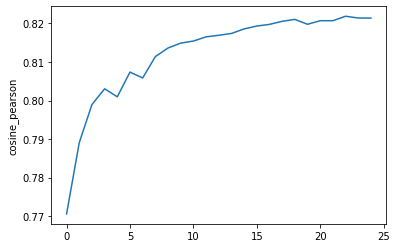

In [18]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

twitter_valid = pd.read_csv(f'models/mpnet-twitter-freq100/eval/similarity_evaluation_results.csv')
# wiki_valid = pd.read_csv(f'models/distilroberta-{dataset}-freq{freq}/eval/similarity_evaluation_results.csv')

sns.lineplot(x=range(len(twitter_valid)), y=twitter_valid['cosine_pearson'])
plt.show()
# sns.lineplot(x=range(len(wiki_valid)), y=wiki_valid['cosine_pearson'])
# plt.show()

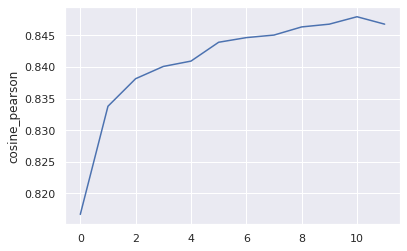

In [99]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

twitter_valid = pd.read_csv(f'models/mpnet-twitter-freq500/eval/similarity_evaluation_results.csv')
# wiki_valid = pd.read_csv(f'models/distilroberta-{dataset}-freq{freq}/eval/similarity_evaluation_results.csv')

sns.lineplot(x=range(len(twitter_valid)), y=twitter_valid['cosine_pearson'])
plt.show()
# sns.lineplot(x=range(len(wiki_valid)), y=wiki_valid['cosine_pearson'])
# plt.show()

## evaluation

### loading saved model

In [ ]:
%env CUDA_VISIBLE_DEVICES=1

In [1]:
from sentence_transformers import SentenceTransformer, models

model = SentenceTransformer('./models/mpnet-twitter-freq100/')

model

SentenceTransformer(
  (0): Transformer({'max_seq_length': 384, 'do_lower_case': False}) with Transformer model: MPNetModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False})
  (2): Normalize()
)

In [2]:
from src.inference.projection import load_sbert_based_model, get_sentence_projections

model = load_sbert_based_model('navidmadani/mpnet-twitter-freq100')
get_sentence_projections(['trump can save us', 'build the wall', 'get vaccinated asap'], model, as_dict=True) 

Getting sentence embeddings


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Projecting embeddings


[{'a': 0.4622251, 'g': 0.66121656, 'e': 0.19234742},
 {'p': 0.3971424,
  'o': 0.6946778,
  'l': 0.29304522,
  'i': 0.019956112,
  't': 0.24655272},
 {'r': 0.45206383,
  'e': -0.30867043,
  'l': -0.38980037,
  'i': 0.15958893,
  'g': 0.2396613}]

### calculating encodings for all phrases

In [ ]:
pis = set()

for bio in cleaned_bios:
    pis.update(bio)

pis = list(pis)
print(len(pis))

embeddings = model.encode(pis, convert_to_tensor=True)
        

In [ ]:
def most_similar(pi, all_pis, all_pi_embs, model, k=11):
    cur_emb = model.encode(pi, convert_to_tensor=True)
    cosine_scores = util.cos_sim(cur_emb, all_pi_embs).detach().cpu().numpy()[0]
    most_similars = np.argsort(cosine_scores)[-k:]
    return [(all_pis[i], cosine_scores[i]) for i in most_similars if pi!=all_pis[i]]

most_similar('mima', pis, embeddings, model, k=50)

In [ ]:
def get_similarity(w1, w2, model=model):
    emb1 = model.encode(w1, convert_to_tensor=True)
    emb2 = model.encode(w2, convert_to_tensor=True)
    return util.cos_sim(emb1, emb2)

print(
    get_similarity('isfj', 'man'),
    get_similarity('isfj', 'woman'),
    get_similarity('isfj', 'man', model=model),
    get_similarity('isfj', 'woman', model=model),
)

print(
    get_similarity('intj', 'man'),
    get_similarity('intj', 'woman'),
    get_similarity('intj', 'man', model=model),
    get_similarity('intj', 'woman', model=model),
)

print(
    get_similarity('entj', 'man'),
    get_similarity('entj', 'woman'),
    get_similarity('entj', 'man', model=model),
    get_similarity('entj', 'woman', model=model),
)


In [ ]:
mom_emb = base_model.encode('intp', convert_to_tensor=True)
dad_emb = base_model.encode('esfj', convert_to_tensor=True)
util.cos_sim(mom_emb, dad_emb)

### loading not tuned model and doing the same thing

In [ ]:
from sentence_transformers import SentenceTransformer, models

base_model = SentenceTransformer('all-MiniLM-L6-v2')
base_embs = base_model.encode(pis, convert_to_tensor=True)
base_cosine_scores = util.cos_sim(base_embs, base_embs).detach().cpu().numpy()

In [ ]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

target_word = 'build the wall'
df1 = pd.DataFrame(most_similar(target_word, pis, embeddings, model), columns=['identifier', 'similarity'])
df1['model'] = 'fine-tuned-sentence-bert'
df2 = pd.DataFrame(most_similar(target_word, pis, base_embs, base_model), columns=['identifier', 'similarity'])
df2['model'] = 'original-sentence-bert'


fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15,6))

ax1.scatter(x=df1['identifier'], y=df1['similarity'])
ax1.tick_params(axis='x', rotation=-60)
ax1.set_xlabel('phrase')
ax1.set_ylabel('similarity')
ax1.set_title('fine-tuned-sentence-bert')


ax2.scatter(x=df2['identifier'], y=df2['similarity'])
ax2.tick_params(axis='x', rotation=-60)
ax2.set_xlabel('phrase')
ax2.set_ylabel('similarity')
ax2.set_title('original-sentence-bert')

plt.show()

### analyzing personalities

In [ ]:
for personality in ['ESTJ', 'ENTJ', 'ESFJ', 'ENFJ', 'ISTJ', 'ISFJ', 'INTJ', 'INFJ', 'ESTP', 'ESFP', 'ENTP', 'ENFP', 'ISTP', 'ISFP', 'INTP', 'INFP']:
    if personality in pis or personality.lower() in pis:
        print(f"{personality}: True")
    else:
        print(f"{personality}: False")

In [ ]:
personalities = ['ESTJ', 'ENTJ', 'ESFJ', 'ENFJ', 'ISTJ', 'ISFJ', 'INTJ', 'INFJ', 'ESTP', 'ESFP', 'ENTP', 'ENFP', 'ISTP', 'ISFP', 'INTP', 'INFP']
personalities = [p.lower() for p in personalities]

pers_emb = model.encode(personalities, convert_to_tensor=True)
pers_emb_base = base_model.encode(personalities, convert_to_tensor=True)

base_cosine_scores = util.cos_sim(pers_emb_base, pers_emb_base).detach().cpu().numpy()
cosine_scores = util.cos_sim(pers_emb, pers_emb).detach().cpu().numpy()

In [ ]:
plt.figure(figsize=(10,10))
ax = sns.heatmap(cosine_scores)
ax.set_xticklabels(personalities, rotation=90)
ax.set_yticklabels(personalities, rotation=0)

# plt.xticks(ticks=personalities)
# plt.yticks(ticks=personalities)

In [ ]:
plt.figure(figsize=(10,10))

ax = sns.heatmap(base_cosine_scores)
ax.set_xticklabels(personalities, rotation=90)
ax.set_yticklabels(personalities, rotation=0)

### comparing in gensim vocab

In [ ]:
import gensim.downloader as api

w2v = api.load("glove-wiki-gigaword-50")
w2v.most_similar("glass")

In [ ]:
vocab = list(w2v.key_to_index.keys())

vocab_embs = model.encode(vocab, convert_to_tensor=True)


In [ ]:
most_similar('vaccine', vocab, vocab_embs, model, k=10)

In [ ]:
most_similar('blm', vocab, vocab_embs, model, k=50)

# Word2vec embedding

In [ ]:
from gensim.models import Word2Vec
from gensim.models.callbacks import CallbackAny2Vec

import pickle

dataset = 'twitter'
freq = 500

with open(f'./data/{dataset}_cleaned_train_bios_{freq}.pkl', 'rb') as f:
    bios = pickle.load(f)
    
print(len(bios))

## number of distinct pis in test and train

In [ ]:
with open(f'./data/{dataset}_test_bios.pkl', 'rb') as f:
    tbios = pickle.load(f)
    
print(len(tbios))

tpis = {}

for tb in tbios:
    for tpi in tb:
        if tpi not in tpis:
            tpis[tpi] = len(tpis)

print(len(tpis))

pis = {}

for b in bios:
    for pi in b:
        if pi not in pis:
            pis[pi] = len(pis)
print(len(pis))

In [ ]:
cnt = 0
for pi in tpis:
    if pi not in pis:
        cnt += 1
        
print(f"{cnt}/{len(tpis)} pis in test are not seen ever")

In [ ]:
def count_bios_with_pi(pi):
    cnt = 0
    for b in bios:
        if pi in b:
            print(b)
            cnt += 1 
    return cnt

count_bios_with_pi('ryan fournier')

In [ ]:
bios[:3]

In [25]:

print(len(bios))

class Callback(CallbackAny2Vec):
    '''Callback to print loss after each epoch.'''

    def __init__(self):
        self.epoch = 0
        self.loss_to_be_subed = 0

    def on_epoch_end(self, model):
        loss = model.get_latest_training_loss()
        loss_now = loss - self.loss_to_be_subed
        self.loss_to_be_subed = loss
        print('Loss after epoch {}: {}'.format(self.epoch, loss_now))
        self.epoch += 1

monitor = Callback()

w2v_negsampling_model = Word2Vec(bios, vector_size=768, window=8, min_count=1,
                 negative=8, workers=30, sg=1, epochs=300, callbacks=[monitor],
                 compute_loss=True)

# w2v_cbow_model = Word2Vec(bios, vector_size=256, window=8, min_count=1,
#                  negative=8, workers=30, sg=0,  cbow_mean=1, epochs=300, callbacks=[monitor],
#                  compute_loss=True)

model_path = f'./models/w2v_negsampling_{dataset}_{freq}.model'
w2v_negsampling_model.save(model_path)

# model_path = f'./models/w2v_cbow_{dataset}_{freq}.model'
# w2v_cbow_model.save(model_path)

2753951
Loss after epoch 0: 1418478.625
Loss after epoch 1: 1329196.875
Loss after epoch 2: 1245573.0
Loss after epoch 3: 1169506.0
Loss after epoch 4: 1075390.0
Loss after epoch 5: 1029586.0
Loss after epoch 6: 1113121.0
Loss after epoch 7: 1014204.5
Loss after epoch 8: 974551.0
Loss after epoch 9: 946892.0
Loss after epoch 10: 1026008.0
Loss after epoch 11: 945799.0
Loss after epoch 12: 845971.0
Loss after epoch 13: 1060943.0
Loss after epoch 14: 1057831.0
Loss after epoch 15: 873495.0
Loss after epoch 16: 996786.0
Loss after epoch 17: 898814.0
Loss after epoch 18: 868850.0
Loss after epoch 19: 1017488.0
Loss after epoch 20: 933150.0
Loss after epoch 21: 938446.0
Loss after epoch 22: 960850.0
Loss after epoch 23: 875164.0
Loss after epoch 24: 958390.0
Loss after epoch 25: 925448.0
Loss after epoch 26: 922576.0
Loss after epoch 27: 833524.0
Loss after epoch 28: 925386.0
Loss after epoch 29: 925046.0
Loss after epoch 30: 904882.0
Loss after epoch 31: 981362.0
Loss after epoch 32: 89962

In [ ]:
model_path = f'./models/w2v_negsampling_{dataset}_{freq}.model'
w2v_model = Word2Vec.load(model_path)

In [ ]:
w2v_model.wv.most_similar('democrat', topn=15)

# hold-one-out prediction of PIs

## load w2v model for vocabulary


In [1]:
%%time

from gensim.models import Word2Vec

model_path = f'./models/w2v_negsampling_twitter_100.model'
w2v_twitter_negsamp_model = Word2Vec.load(model_path)

# model_path = f'./models/w2v_cbow_twitter.model'
# w2v_twitter_cbow_model = Word2Vec.load(model_path)

# model_path = f'./models/w2v_negsampling_wiki.model'
# w2v_wiki_negsamp_model = Word2Vec.load(model_path)

model_path = f'./models/w2v_cbow_wiki_3.model'
w2v_wiki_cbow_model = Word2Vec.load(model_path)



CPU times: user 897 ms, sys: 2.21 s, total: 3.11 s
Wall time: 2.19 s


## load and filter data

In [2]:
%%time

from tqdm import tqdm_notebook as tqdm
from collections import Counter
import pickle
from collections import OrderedDict
import numpy as np


def load_bios(dataset='twitter', mode='test'):
    with open(f'data/{dataset}_{mode}_bios.pkl', 'rb') as f:
        bios = pickle.load(f)
    
    #filter only bios with more than 1 PI
    morethan2pi = [x for x in bios if len(x)>1]
    return morethan2pi

def build_vocab_list(bios):
    all_pis = set()
    for bio in bios:
        all_pis.update(bio)

    return list(all_pis)

def filter_bios_with_vocab_restriction(bios, vocab):
    if vocab is None:
        return bios
    
    filtered_bios = []
    for bio in bios:
        cur_bio = []
        for pi in bio:
            if pi in vocab:
                cur_bio.append(pi)
        if len(cur_bio) > 1:
            filtered_bios.append(cur_bio)
    return filtered_bios

def build_contextual_dataset(bios):
    test_ds = []
    test_ds_rand = []
    
    for bio in bios:
        hold_out_idx = np.random.randint(0, len(bio))
        remaining = [x for i, x in enumerate(bio) if i != hold_out_idx]
        random_remaining = list(np.random.choice(remaining, 1))[0]
        
        remaining = ', '.join(remaining)
        target = bio[hold_out_idx]

        test_ds.append((remaining, target))
        test_ds_rand.append((random_remaining, target))

    return test_ds, test_ds_rand


def build_w2v_dataset(bios):
    w2v_test_ds = []
    w2v_test_random_ds = []

    for bio in bios:
        hold_out_idx = np.random.randint(0, len(bio))
        remaining = [x for i, x in enumerate(bio) if i != hold_out_idx]
        random_remaining = list(np.random.choice(remaining, 1))
        target = bio[hold_out_idx]

        w2v_test_ds.append((remaining, target))
        w2v_test_random_ds.append((random_remaining, target))
    
    return w2v_test_ds, w2v_test_random_ds


def filter_with_freq(bios, freq=500):
    cntr = Counter()
    for bio in bios:
        cntr.update(bio)
        
    filtered_bios = []
    for bio in bios:
        cur = []
        for pi in bio:
            if cntr[pi] >= freq:
                cur.append(pi)
        if len(cur) > 1:
            filtered_bios.append(cur)
    return filtered_bios
            

def create_test_dataset(dataset='twitter', restrict_vocab_to_training=None, w2v=False, filter_th=None):
    print(f"creating dataset for {dataset}:")
    
    test_bios = load_bios(dataset)
    print(f"total test bios: {len(test_bios)}")
    
    test_bios = filter_bios_with_vocab_restriction(test_bios, restrict_vocab_to_training)
    print(f"total test bios after restriction: {len(test_bios)}")
    
    if filter_th is not None:
        test_bios = filter_with_freq(test_bios, freq=filter_th)
        print(f"total test bios after freq filter: {len(test_bios)}")
    
    test_pis = build_vocab_list(test_bios)
    print(f"total PIs: {len(test_pis)}")
    
    pi_dict = OrderedDict()
    for p in test_pis:
        pi_dict[p] = len(pi_dict)
    
    if w2v:
        test_ds, test_ds_rand = build_w2v_dataset(test_bios)
        return test_ds, test_ds_rand, pi_dict
    else:
        test_ds, test_ds_rand = build_contextual_dataset(test_bios)
        return test_ds, test_ds_rand, pi_dict
        
    
def build_restricted_target_dataset(bios, vocab, generalization):
    test_ds = []
    
    for bio in bios:
        for idx, pi in enumerate(bio):
            if pi in vocab:
                remaining = [x for x in bio if x != pi]
                
                # we want the remainig not to be available in vocab to test generalization
                if generalization:
                    gen = True
                    for rem in remaining:
                        if rem in vocab:
                            gen = False
                    
                    if not gen:
                        continue
                
                remaining_ctxt = ', '.join(remaining)
                if len(remaining) == 0:
                    continue
                test_ds.append((remaining, remaining_ctxt, pi))
            
    return test_ds


def create_restricted_target_test_dataset(dataset, vocab, generalization=False):
    print(f"creating dataset for {dataset}:")
    
    test_bios = load_bios(dataset)
    print(f"total test bios: {len(test_bios)}")
    
    filtered_test_bios = []
    for bio in test_bios:
        for pi in bio:
            if pi in vocab:
                filtered_test_bios.append(bio)
                break
                
    print(f"total test bios after restriction: {len(filtered_test_bios)}")
    
    test_ds = build_restricted_target_dataset(filtered_test_bios, vocab, generalization)
    print(f"total test dataset entires: ", len(test_ds))
    print(f"vocab size:", len(vocab))
    return test_ds, vocab
    
    
    

CPU times: user 2.91 ms, sys: 1.43 ms, total: 4.35 ms
Wall time: 28.6 ms


In [ ]:
w2v_twitter_negsamp_model.wv.key_to_index



In [3]:
test_ds_twitter_target_restricted, twitter_target_restricted_pis = create_restricted_target_test_dataset(
    dataset='twitter',
    vocab=w2v_twitter_negsamp_model.wv.key_to_index,
    generalization=False
)


# sampling test sets for faster results
sample_indices = np.random.randint(0, len(test_ds_twitter_target_restricted), 100000)
test_ds_twitter_target_restricted = [test_ds_twitter_target_restricted[i] for i in sample_indices]



# test_ds_wiki_target_restricted, wiki_target_restricted_pis = create_restricted_target_test_dataset(
#     dataset='wiki',
#     vocab=w2v_wiki_cbow_model.wv.key_to_index,
# )


creating dataset for twitter:
total test bios: 1546001
total test bios after restriction: 1279200
total test dataset entires:  3439676
vocab size: 22516


In [ ]:
test_ds_twitter_target_restricted[:5]



In [6]:

'diy projects' in w2v_twitter_negsamp_model.wv.key_to_index



False

## helper function for batching

In [4]:
from tqdm import tqdm
import torch 

def get_results_batched(model, tokenizer, str_l, bs=256, average_k_layers=1):
    i = 0
    result = []
    pbar = tqdm(total=len(str_l))
    while i < len(str_l):
        batch = list(str_l[i:i+bs])
        with torch.no_grad():
            tokens = tokenizer(batch, return_tensors='pt', padding=True, truncation=True).to(device)
            res_full = model(**tokens, output_hidden_states=True).hidden_states
            layers = []

            for k in range(-average_k_layers,0):
                pooled_val = res_full[k].detach().cpu()
                # taking cls token embeddings
                layers.append(pooled_val[:,0,:])

            stacked_layers = torch.stack(layers, dim=1)
            #print(stacked_layers.shape)

            average_embs = torch.mean(stacked_layers, dim=1)
            #print(average_embs.shape)

            result.append(average_embs)
            i = i + bs
            pbar.update(bs)
    return torch.concat(result, dim=0)


def get_sbertbased_results_batched(model, str_l, bs=256):
    i = 0
    result = []
    pbar = tqdm(total=len(str_l))
    while i < len(str_l):
        batch = list(str_l[i:i+bs])
        with torch.no_grad():
            embeddings = model.encode(batch, convert_to_tensor=True)
            result.append(embeddings.detach().cpu())
            
            i = i + bs
            pbar.update(bs)
    return torch.concat(result, dim=0)


## word2vec

### full dataset

In [ ]:
w2v_test_ds_twitter, _, twitter_pi_dict = create_test_dataset(
    dataset='twitter',
    w2v=True
)

w2v_test_ds_wiki, _, wiki_pi_dict = create_test_dataset(
    dataset='wiki',
    w2v=True
)

print(len(w2v_test_ds_twitter), len(twitter_pi_dict))
print(len(w2v_test_ds_wiki), len(wiki_pi_dict))

### dataset with restriction

In [5]:


# dataset for fixed target
fixed_target_twitter_w2v_ds = [(x[0], x[2]) for x in test_ds_twitter_target_restricted]
# fixed_target_wiki_w2v_ds = [(x[0], x[2]) for x in test_ds_wiki_target_restricted]


### measure metrics

In [6]:
%%time
import torch
from sentence_transformers import SentenceTransformer, models, util
from tqdm import tqdm
from torch.nn.functional import log_softmax

def normalize(word_vectors):
    norms = torch.norm(word_vectors, dim=1, keepdim=True)
    res = word_vectors / (norms + 1e-6)
    return res


def calculate_w2v_based_metrics(w2v_model, dataset, pi_dict, device='cpu', cosine_bs=512, return_ranks=False):
    pi_list = list(pi_dict.keys())
    X, ys = zip(*dataset)
    
    emb_x = torch.tensor([w2v_model.wv.get_mean_vector(x) for x in X], device=device)
    emb_all = torch.tensor([w2v_model.wv.get_vector(x) for x in pi_list], device=device)
    
    emb_x = normalize(emb_x)
    emb_all = normalize(emb_all)
    
    print("calculating ranks...")
    
    i = 0
    pbar = tqdm(total=emb_x.shape[0])

    target_ranks = []
    softmax_scores = []
    
    while i < emb_x.shape[0]:
        batch = emb_x[i:i+cosine_bs]
        batch_y = ys[i:i+cosine_bs]
        batch_cosine_scores = util.cos_sim(batch.to(device), emb_all.to(device))
        batch_softmax = log_softmax(batch_cosine_scores, dim=1)
#         print(torch.sum(batch_softmax, dim=1), torch.sum(batch_softmax, dim=1).shape)
        ranks = torch.argsort(torch.argsort(batch_cosine_scores, dim=1, descending=True), dim=1)
        target_idxs = torch.tensor([pi_dict[y] for y in batch_y], dtype=torch.int64, device=device)
        
        batch_target_ranks = torch.gather(ranks, 1, target_idxs.unsqueeze(1).reshape(-1,1)).type(torch.FloatTensor)
        batch_target_scores = torch.gather(batch_softmax, 1, target_idxs.unsqueeze(1).reshape(-1,1)).type(torch.FloatTensor)
        
        target_ranks.append(batch_target_ranks)
        softmax_scores.append(batch_target_scores)
        
        i += cosine_bs
        pbar.update(cosine_bs)


    target_ranks = torch.concat(target_ranks)
    softmax_scores = torch.concat(softmax_scores)
    
#     print(softmax_scores)

    avg_score = torch.mean(softmax_scores).item()
    avg_rank = torch.mean(target_ranks).item()
#     
    top100_acc = len([r for r in target_ranks.reshape(1,-1).squeeze().tolist() if r < len(pi_list)//100])/emb_x.shape[0]
    
    print(avg_rank, top100_acc, avg_score)
    
    if return_ranks:
        return avg_rank, top100_acc, avg_score, target_ranks.tolist()

    return avg_rank, top100_acc, avg_score
    
    

/projects/academic/kjoseph/navid/anaconda3/envs/py38/lib/python3.8/site-packages/huggingface_hub/snapshot_download.py:6: FutureWarning: snapshot_download.py has been made private and will no longer be available from version 0.11. Please use `from huggingface_hub import snapshot_download` to import the only public function in this module. Other members of the file may be changed without a deprecation notice.
  warnings.warn(


CPU times: user 329 ms, sys: 84.8 ms, total: 414 ms
Wall time: 2.97 s


### compare different w2v models

In [ ]:
%%time


# twitterrand_w2v_cbow_avgrank, twitterrand_w2v_cbow_top100acc = calculate_w2v_based_metrics(
#     w2v_model=w2v_twitter_cbow_model,
#     dataset=w2v_test_ds_twitter_rand,
#     pi_dict=twitter_pi_dict,
# )

# twitterrand_w2v_negsample_avgrank, twitterrand_w2v_negsample_top100acc = calculate_w2v_based_metrics(
#     w2v_model=w2v_twitter_negsamp_model,
#     dataset=w2v_test_ds_twitter_rand,
#     pi_dict=twitter_pi_dict,
# )

# wikirand_w2v_cbow_avgrank, wikirand_w2v_cbow_top100acc = calculate_w2v_based_metrics(
#     w2v_model=w2v_wiki_cbow_model,
#     dataset=w2v_test_ds_wiki_rand,
#     pi_dict=wiki_pi_dict,
# )

# wikirand_w2v_negsample_avgrank, wikirand_w2v_negsample_top100acc = calculate_w2v_based_metrics(
#     w2v_model=w2v_wiki_negsamp_model,
#     dataset=w2v_test_ds_wiki_rand,
#     pi_dict=wiki_pi_dict,
# )

# twitter_w2v_cbow_avgrank, twitter_w2v_cbow_top100acc = calculate_w2v_based_metrics(
#     w2v_model=w2v_twitter_cbow_model,
#     dataset=w2v_test_ds_twitter,
#     pi_dict=twitter_pi_dict,
# )

twitter_w2v_negsample_avgrank, twitter_w2v_negsample_top100acc = calculate_w2v_based_metrics(
    w2v_model=w2v_twitter_negsamp_model,
    dataset=w2v_test_ds_twitter,
    pi_dict=twitter_pi_dict,
)

wiki_w2v_cbow_avgrank, wiki_w2v_cbow_top100acc = calculate_w2v_based_metrics(
    w2v_model=w2v_wiki_cbow_model,
    dataset=w2v_test_ds_wiki,
    pi_dict=wiki_pi_dict,
)

# wiki_w2v_negsample_avgrank, wiki_w2v_negsample_top100acc = calculate_w2v_based_metrics(
#     w2v_model=w2v_wiki_negsamp_model,
#     dataset=w2v_test_ds_wiki,
#     pi_dict=wiki_pi_dict,
# )



### run fixed target experiment

In [7]:
twitter_w2v_negsample_avgrank, twitter_w2v_negsample_top100acc, twitter_w2v_negsample_avgscore, twitter_w2v_negsample_ranks = calculate_w2v_based_metrics(
    w2v_model=w2v_twitter_negsamp_model,
    dataset=fixed_target_twitter_w2v_ds,
    pi_dict=twitter_target_restricted_pis,
    cosine_bs=2000,
    return_ranks=True
)

# wiki_w2v_cbow_avgrank, wiki_w2v_cbow_top100acc, wiki_w2v_cbow_avgscore, wiki_w2v_cbow_ranks = calculate_w2v_based_metrics(
#     w2v_model=w2v_wiki_cbow_model,
#     dataset=fixed_target_wiki_w2v_ds,
#     pi_dict=wiki_target_restricted_pis,
#     cosine_bs=2000,
#     return_ranks=True
# )

<timed exec>:16: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1634272068694/work/torch/csrc/utils/tensor_new.cpp:201.)


calculating ranks...


100%|██████████| 100000/100000 [05:49<00:00, 286.25it/s]

4173.19921875 0.43113 -9.892007827758789


### visualize results

In [ ]:
import seaborn as sns
sns.set_theme()

import matplotlib.pyplot as plt
import pandas as pd

df = pd.DataFrame({
    'model': ['w2v_cbow', 'w2v_negsample', 'w2v_cbow', 'w2v_negsample',
              'w2v_cbow', 'w2v_negsample', 'w2v_cbow', 'w2v_negsample'],
    'dataset': ['twitter', 'wiki', 'wiki', 'twitter', 'twitter_rand', 'wiki_rand', 'wiki_rand', 'twitter_rand',],
    'avg_rank': [twitter_w2v_cbow_avgrank, wiki_w2v_negsample_avgrank, wiki_w2v_cbow_avgrank,
                 twitter_w2v_negsample_avgrank, twitterrand_w2v_cbow_avgrank, wikirand_w2v_negsample_avgrank, wikirand_w2v_cbow_avgrank,
                 twitterrand_w2v_negsample_avgrank],
    'top100_acc': [twitter_w2v_cbow_top100acc, wiki_w2v_negsample_top100acc, wiki_w2v_cbow_top100acc,
                   twitter_w2v_negsample_top100acc, twitterrand_w2v_cbow_top100acc, wikirand_w2v_negsample_top100acc, wikirand_w2v_cbow_top100acc,
                   twitterrand_w2v_negsample_top100acc],
    
})

sns.barplot(data=df, x='model', y='top100_acc', hue='dataset')
plt.show()

sns.barplot(data=df, x='model', y='avg_rank', hue='dataset')
plt.show()


## Contextual LMs

### load datasets

#### restricted vocab datasets

In [ ]:
clm_test_ds_twitter, clm_test_ds_twitter_rand, twitter_pi_dict = create_test_dataset(
    dataset='twitter',
    restrict_vocab_to_training=w2v_twitter_negsamp_model.wv.key_to_index,
    w2v=False
)

clm_test_ds_wiki, clm_test_ds_wiki_rand, wiki_pi_dict = create_test_dataset(
    dataset='wiki',
    restrict_vocab_to_training=w2v_wiki_negsamp_model.wv.key_to_index,
    w2v=False
)

#### full test dataset

In [ ]:
clm_test_ds_full_twitter, _, twitter_pi_dict_full = create_test_dataset(
    dataset='twitter',
    restrict_vocab_to_training=None,
    w2v=False,
    filter_th=10
)

clm_test_ds_full_wiki, _, wiki_pi_dict_full = create_test_dataset(
    dataset='wiki',
    restrict_vocab_to_training=None,
    w2v=False,
    filter_th=None
)

#### target restricted dataset

In [8]:
fixed_target_twitter_clm_ds = [(x[1], x[2]) for x in test_ds_twitter_target_restricted]
# fixed_target_wiki_clm_ds = [(x[1], x[2]) for x in test_ds_wiki_target_restricted]


### load different models

#### load BERT

In [9]:
from transformers import BertTokenizer, BertModel, BertConfig
import torch

device = 'cuda:0'

config = BertConfig.from_pretrained("bert-base-uncased", output_hidden_states=True)
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
bert_model = BertModel.from_pretrained("bert-base-uncased", config=config)
bert_model = bert_model.to(device)
bert_model.eval()

# config = BertConfig.from_pretrained("bert-large-uncased", output_hidden_states=True)
# bertlarge_tokenizer = BertTokenizer.from_pretrained("bert-large-uncased")
# bertlarge_model = BertModel.from_pretrained("bert-large-uncased", config=config)
# bertlarge_model = bertlarge_model.to(device)
# bertlarge_model.eval()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          

#### load RoBERTa

In [10]:
%%time

from sentence_transformers import SentenceTransformer, models, util
from transformers import AutoTokenizer, AutoModel


device = 'cuda:0'
roberta_model = AutoModel.from_pretrained("roberta-base")
roberta_tokenizer = AutoTokenizer.from_pretrained("roberta-base", use_fast=False)

roberta_model = roberta_model.to(device)
roberta_model.eval()

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


CPU times: user 2.29 s, sys: 314 ms, total: 2.6 s
Wall time: 3.19 s


RobertaModel(
  (embeddings): RobertaEmbeddings(
    (word_embeddings): Embedding(50265, 768, padding_idx=1)
    (position_embeddings): Embedding(514, 768, padding_idx=1)
    (token_type_embeddings): Embedding(1, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): RobertaEncoder(
    (layer): ModuleList(
      (0): RobertaLayer(
        (attention): RobertaAttention(
          (self): RobertaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): RobertaSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
            (dropout): Drop

### load bert fine tuned

In [11]:
%%time

from sentence_transformers import SentenceTransformer, models, util
from transformers import AutoTokenizer, AutoModel


device = 'cuda:0'
bert_ft_tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased", use_fast=False)
# bertlarge_ft_tokenizer = AutoTokenizer.from_pretrained("bert-large-uncased", use_fast=False)

bert_ft_twitter_model = AutoModel.from_pretrained("./models/bert-ft-mlm-twitter-v2/checkpoint-250000/")
bert_ft_twitter_model = bert_ft_twitter_model.to(device)
bert_ft_twitter_model.eval()

# bertlarge_ft_twitter_model = AutoModel.from_pretrained("./models/bertlarge-ft-mlm-twitter/checkpoint-3904/")
# bertlarge_ft_twitter_model = bertlarge_ft_twitter_model.to(device)
# bertlarge_ft_twitter_model.eval()




# bert_ft50_twitter_model = AutoModel.from_pretrained("./models/bert-ft-mlm-twitter/checkpoint-24992/")
# bert_ft50_twitter_model = bert_ft50_twitter_model.to(device)
# bert_ft50_twitter_model.eval()

bert_ft_wiki_model = AutoModel.from_pretrained("./models/bert-ft-mlm-wiki/checkpoint-29328/")
bert_ft_wiki_model = bert_ft_wiki_model.to(device)
bert_ft_wiki_model.eval()



Some weights of the model checkpoint at ./models/bert-ft-mlm-twitter-v2/checkpoint-250000/ were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertModel were not initialized from the model checkpoint at ./models/bert-ft-mlm-twitter-v2/checkpoint-250000/ and are newly initializ

CPU times: user 8.01 s, sys: 379 ms, total: 8.39 s
Wall time: 2.97 s


BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          

#### load sentenceBERT

In [12]:
%%time

from sentence_transformers import SentenceTransformer, models, util
from transformers import AutoTokenizer, AutoModel

device = 'cuda:0'

sbert_model = SentenceTransformer('all-mpnet-base-v2', device=device)
# sbert_model = SentenceTransformer('all-distilroberta-v1', device=device)
# sbert_model = SentenceTransformer('all-MiniLM-L6-v2', device=device)
sbert_model.eval()


/projects/academic/kjoseph/navid/anaconda3/envs/py38/lib/python3.8/site-packages/huggingface_hub/file_download.py:588: FutureWarning: `cached_download` is the legacy way to download files from the HF hub, please consider upgrading to `hf_hub_download`
  warnings.warn(


CPU times: user 9.9 s, sys: 285 ms, total: 10.2 s
Wall time: 2.59 s


SentenceTransformer(
  (0): Transformer({'max_seq_length': 384, 'do_lower_case': False}) with Transformer model: MPNetModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False})
  (2): Normalize()
)

#### load sentenceBERT fine-tuned

In [9]:
%%time

from sentence_transformers import SentenceTransformer, models, util
from transformers import AutoTokenizer, AutoModel


device = 'cuda:0'
twitter_ft_sbert = SentenceTransformer('./models/mpnet-twitter-freq100', device=device)
twitter_ft_sbert.eval()

# twitter_ft_sbert_10p = SentenceTransformer('./models/distilroberta-twitter-freq100-10p/', device=device)
# twitter_ft_sbert_10p.eval()

wiki_ft_sbert = SentenceTransformer('./models/mpnet-wiki-freq3/', device=device)
wiki_ft_sbert.eval()

# wiki_ft_sbert = SentenceTransformer('./models/miniLM-L6-wiki-out256/', device=device)
# wiki_ft_sbert.eval()

# twitter_ft_sbert = SentenceTransformer('./models/miniLM-L6-twitter-out256/', device=device)
# twitter_ft_sbert.eval()

# wiki_ft_sbert = SentenceTransformer('./models/miniLM-L6-wiki-out256/', device=device)
# wiki_ft_sbert.eval()


CPU times: user 10.2 s, sys: 686 ms, total: 10.9 s
Wall time: 5.41 s


SentenceTransformer(
  (0): Transformer({'max_seq_length': 384, 'do_lower_case': False}) with Transformer model: MPNetModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False})
  (2): Normalize()
)

## projection model 

### define dimensions

In [33]:
# measures = [{
#     "group": "age",
#     "names": ['young', 'old'],
#     "sets": [['young'], ['old']],
#     "paper": "this_short",
#     "is_paired": True
# }, {
#     "group":
#     "age",
#     "names": ['young', 'old'],
#     "sets": [['young', 'new', 'youthful', 'young'],
#              ['old', 'old', 'elderly', 'aged']],
#     "paper":
#     "this_long",
#     "is_paired":
#     True
# }, {
#     "group": "gender",
#     "names": ['woman', 'man'],
#     "sets": [['female'], ['male']],
#     "paper": "this_short",
#     "is_paired": True
# }, {
#     "group": "gender",
#     "names": ['woman', 'man'],
#     "sets": [['she'], ['he']],
#     "paper": "gonen",
#     "is_paired": True
# }, {
#     "group":
#     "gender",
#     "names": ['woman', 'man'],
#     "sets": [[
#         'woman', 'girl', 'she', 'mother', 'daughter', 'gal', 'female', 'her',
#         'herself', 'Mary'
#     ],
#              [
#                  'man', 'boy', 'he', 'father', 'son', 'guy', 'male', 'his',
#                  'himself', 'John'
#              ]],
#     "paper":
#     "bolukbasi_words",
#     "is_paired":
#     True
# }, {
#     "group":
#     "gender",
#     "names": ['woman', 'man'],
#     "sets":
#     [['amy', 'joan', 'lisa', 'sarah', 'diana', 'kate', 'ann', 'donna'],
#      ['john', 'paul', 'mike', 'kevin', 'steve', 'greg', 'jeff', 'bill']],
#     "paper":
#     "bolukbasi_names",
#     "is_paired":
#     True
# }, {
#     "group":
#     "gender",
#     "names": ['woman', 'man'],
#     "sets": [[
#         'woman', 'women', 'she', 'her', 'her', 'hers', 'girl', 'girls',
#         'female', 'feminine'
#     ],
#              [
#                  'man', 'men', 'he', 'him', 'his', 'his', 'boy', 'boys',
#                  'male', 'masculine'
#              ]],
#     "paper":
#     "kozlowski",
#     "is_paired":
#     True
# }]


# race_ethnicities = ['white', 'latino', 'asian', 'middle eastern', 'black']

# measures += [{
#     "sets": [['white', 'White'], ['hispanic', 'Hispanic', 'latino', 'Latino'],
#              ['asian', 'Asian'], ['arab', 'Arab'], ['black', 'Black']],
#     "names":
#     race_ethnicities,
#     "group":
#     "race_ethnicity",
#     "paper":
#     "this_short",
#     "is_paired":
#     False
# }, {
#     "sets":
#     [['white', 'whites', 'White', 'Whites', 'European', 'Caucasian', 'Anglo'],
#      [
#          'hispanic', 'hispanics', 'Hispanic', 'Hispanics', 'Mexican', 'Latino',
#          'Hispanic'
#      ],
#      ['asian', 'asians', 'Asian', 'Asians', 'Chinese', 'Japanese', 'Korean'],
#      ['arab', 'arabs', 'Arab', 'Arabs', 'Muslim', 'Muslim', 'Muslim'],
#      ['black', 'blacks', 'Black', 'Blacks', 'African', 'African', 'Afro']],
#     "names":
#     race_ethnicities,
#     "group":
#     "race_ethnicity",
#     "paper":
#     "koslowski",
#     "is_paired":
#     False
# }, {
#     "sets": [['white', 'whites', 'european', 'caucasian', 'anglo'],
#              ['hispanic', 'hispanics', 'mexican', 'latino', 'hispanic'],
#              ['asian', 'asians', 'chinese', 'japanese', 'korean'],
#              ['arab', 'arabs', 'muslims', 'muslim', 'arab'],
#              ['black', 'blacks', 'african', 'african', 'afro']],
#     "names":
#     race_ethnicities,
#     "group":
#     "race_ethnicity",
#     "paper":
#     "koslowski_lowercase",
#     "is_paired":
#     False
# }, {
#     "sets":
#     [['white', 'whites', 'White', 'Whites', 'European', 'Caucasian', 'Anglo'],
#      [
#          'hispanic', 'hispanics', 'Hispanic', 'Hispanics', 'Mexican', 'latino',
#          'latinos', 'latina', 'latinas', 'Latino', 'Latinos', 'Latina',
#          'Latinas'
#      ],
#      ['asian', 'asians', 'Asian', 'Asians', 'Chinese', 'Japanese', 'Korean'],
#      [
#          'arab', 'arabs', 'Arab', 'Arabs', 'Muslim', 'Muslims', 'Muslim',
#          'Muslims'
#      ], [
#          'black',
#          'blacks',
#          'Black',
#          'Blacks',
#          'African',
#          'African',
#      ]],
#     "names":
#     race_ethnicities,
#     "group":
#     "race_ethnicity",
#     "paper":
#     "this_long",
#     "is_paired":
#     False
# }]


# measures.append({
#     "group":
#     "politics",
#     "names": ['republican', 'democrat'],
#     "sets": [['republican', 'conservative'], ['democrat', 'democratic']],
#     "paper":
#     "unk",
#     "is_paired":
#     True
# })

In [34]:
measures = [{
    "group": "age",
    "names": ['young', 'old'],
    "sets": [['young'], ['old']],
    "paper": "this_short",
    "is_paired": True
}, {
    "group":
    "age",
    "names": ['young', 'old'],
    "sets": [['young', 'new', 'youthful', 'young'],
             ['old', 'old', 'elderly', 'aged']],
    "paper":
    "this_long",
    "is_paired":
    True
}, {
    "group": "gender",
    "names": ['woman', 'man'],
    "sets": [['female'], ['male']],
    "paper": "this_short",
    "is_paired": True
}, {
    "group": "gender",
    "names": ['woman', 'man'],
    "sets": [['she'], ['he']],
    "paper": "gonen",
    "is_paired": True
}, {
    "group":
    "gender",
    "names": ['woman', 'man'],
    "sets": [[
        'woman', 'girl', 'she', 'mother', 'daughter', 'gal', 'female', 'her',
        'herself', 'Mary'
    ],
             [
                 'man', 'boy', 'he', 'father', 'son', 'guy', 'male', 'his',
                 'himself', 'John'
             ]],
    "paper":
    "bolukbasi_words",
    "is_paired":
    True
}, {
    "group":
    "gender",
    "names": ['woman', 'man'],
    "sets":
    [['amy', 'joan', 'lisa', 'sarah', 'diana', 'kate', 'ann', 'donna'],
     ['john', 'paul', 'mike', 'kevin', 'steve', 'greg', 'jeff', 'bill']],
    "paper":
    "bolukbasi_names",
    "is_paired":
    True
}, {
    "group":
    "gender",
    "names": ['woman', 'man'],
    "sets": [[
        'woman', 'women', 'she', 'her', 'her', 'hers', 'girl', 'girls',
        'female', 'feminine'
    ],
             [
                 'man', 'men', 'he', 'him', 'his', 'his', 'boy', 'boys',
                 'male', 'masculine'
             ]],
    "paper":
    "kozlowski",
    "is_paired":
    True
}]


race_ethnicities = ['white', 'latino', 'asian', 'middle eastern', 'black']

measures += [{
    "sets": [['white', 'White'], ['hispanic', 'Hispanic', 'latino', 'Latino'],
             ['asian', 'Asian'], ['arab', 'Arab'], ['black', 'Black']],
    "names":
    race_ethnicities,
    "group":
    "race_ethnicity",
    "paper":
    "this_short",
    "is_paired":
    False
}, {
    "sets":
    [['white', 'whites', 'White', 'Whites', 'European', 'Caucasian', 'Anglo'],
     [
         'hispanic', 'hispanics', 'Hispanic', 'Hispanics', 'Mexican', 'Latino',
         'Hispanic'
     ],
     ['asian', 'asians', 'Asian', 'Asians', 'Chinese', 'Japanese', 'Korean'],
     ['arab', 'arabs', 'Arab', 'Arabs', 'Muslim', 'Muslim', 'Muslim'],
     ['black', 'blacks', 'Black', 'Blacks', 'African', 'African', 'Afro']],
    "names":
    race_ethnicities,
    "group":
    "race_ethnicity",
    "paper":
    "koslowski",
    "is_paired":
    False
}, {
    "sets": [['white', 'whites', 'european', 'caucasian', 'anglo'],
             ['hispanic', 'hispanics', 'mexican', 'latino', 'hispanic'],
             ['asian', 'asians', 'chinese', 'japanese', 'korean'],
             ['arab', 'arabs', 'muslims', 'muslim', 'arab'],
             ['black', 'blacks', 'african', 'african', 'afro']],
    "names":
    race_ethnicities,
    "group":
    "race_ethnicity",
    "paper":
    "koslowski_lowercase",
    "is_paired":
    False
}, {
    "sets":
    [['white', 'whites', 'White', 'Whites', 'European', 'Caucasian', 'Anglo'],
     [
         'hispanic', 'hispanics', 'Hispanic', 'Hispanics', 'Mexican', 'latino',
         'latinos', 'latina', 'latinas', 'Latino', 'Latinos', 'Latina',
         'Latinas'
     ],
     ['asian', 'asians', 'Asian', 'Asians', 'Chinese', 'Japanese', 'Korean'],
     [
         'arab', 'arabs', 'Arab', 'Arabs', 'Muslim', 'Muslims', 'Muslim',
         'Muslims'
     ], [
         'black',
         'blacks',
         'Black',
         'Blacks',
         'African',
         'African',
     ]],
    "names":
    race_ethnicities,
    "group":
    "race_ethnicity",
    "paper":
    "this_long",
    "is_paired":
    False
}]


measures.append({
    "group":
    "politics",
    "names": ['republican', 'democrat'],
    "sets": [['republican', 'conservative'], ['democrat', 'democratic']],
    "paper":
    "unk",
    "is_paired":
    True
})

measures.append({
    "group":
    "religion",
    "names": ['religious', 'atheist'],
    "sets": [['religious', 'believe in god', 'christian', 'believe in lord'], ['atheist', 'agnostic', 'skeptic']],
    "paper":
    "unk",
    "is_paired":
    True
})

### get poles

In [35]:
dims = {}
for m in measures:
    if m['group'] in dims:
        dims[m['group']][0].extend(m['sets'][0])
        dims[m['group']][1].extend(m['sets'][1])
    else:
        dims[m['group']] = [m['sets'][0], m['sets'][1]]
        
for g, p in dims.items():
    p[0] = list(set(p[0]))
    p[1] = list(set(p[1]))
    
len(dims), dims

(5,
 {'age': [['young', 'new', 'youthful'], ['old', 'aged', 'elderly']],
  'gender': [['feminine',
    'her',
    'daughter',
    'Mary',
    'woman',
    'herself',
    'lisa',
    'women',
    'gal',
    'donna',
    'girl',
    'girls',
    'sarah',
    'female',
    'hers',
    'ann',
    'mother',
    'she',
    'joan',
    'diana',
    'amy',
    'kate'],
   ['kevin',
    'him',
    'greg',
    'mike',
    'he',
    'himself',
    'son',
    'boy',
    'bill',
    'steve',
    'jeff',
    'male',
    'paul',
    'masculine',
    'John',
    'man',
    'john',
    'father',
    'his',
    'guy',
    'men',
    'boys']],
  'race_ethnicity': [['white',
    'european',
    'anglo',
    'European',
    'Anglo',
    'caucasian',
    'Whites',
    'whites',
    'Caucasian',
    'White'],
   ['latina',
    'latino',
    'latinas',
    'mexican',
    'hispanics',
    'hispanic',
    'Hispanic',
    'latinos',
    'Latinos',
    'Latina',
    'Latinas',
    'Mexican',
    'Latino',
    'Hi

In [36]:
dims.pop('race_ethnicity')

dims['race_ethnicity_wh'] = [
    ['white', 'whites', 'White', 'Whites', 'European', 'Caucasian', 'Anglo'],
    [
        'hispanic', 'hispanics', 'Hispanic', 'Hispanics', 'Mexican', 'latino',
        'latinos', 'latina', 'latinas', 'Latino', 'Latinos', 'Latina',
        'Latinas'
    ]
]

dims['race_ethnicity_was'] = [
    ['white', 'whites', 'White', 'Whites', 'European', 'Caucasian', 'Anglo'],
    ['asian', 'asians', 'Asian', 'Asians', 'Chinese', 'Japanese', 'Korean'],
]

dims['race_ethnicity_wme'] = [[
    'white', 'whites', 'White', 'Whites', 'European', 'Caucasian', 'Anglo'
], [
    'arab', 'arabs', 'Arab', 'Arabs', 'Muslim', 'Muslims', 'Muslim', 'Muslims', 'middle eastern', 'mideast', 'iranian'
]]

dims['race_ethnicity_wb'] = [[
    'white', 'whites', 'White', 'Whites', 'European', 'Caucasian', 'Anglo'
], [
    'black','blacks','Black','Blacks','African','African',
]]

dims

{'age': [['young', 'new', 'youthful'], ['old', 'aged', 'elderly']],
 'gender': [['feminine',
   'her',
   'daughter',
   'Mary',
   'woman',
   'herself',
   'lisa',
   'women',
   'gal',
   'donna',
   'girl',
   'girls',
   'sarah',
   'female',
   'hers',
   'ann',
   'mother',
   'she',
   'joan',
   'diana',
   'amy',
   'kate'],
  ['kevin',
   'him',
   'greg',
   'mike',
   'he',
   'himself',
   'son',
   'boy',
   'bill',
   'steve',
   'jeff',
   'male',
   'paul',
   'masculine',
   'John',
   'man',
   'john',
   'father',
   'his',
   'guy',
   'men',
   'boys']],
 'politics': [['republican', 'conservative'], ['democratic', 'democrat']],
 'religion': [['believe in god', 'religious', 'believe in lord', 'christian'],
  ['atheist', 'agnostic', 'skeptic']],
 'race_ethnicity_wh': [['white',
   'whites',
   'White',
   'Whites',
   'European',
   'Caucasian',
   'Anglo'],
  ['hispanic',
   'hispanics',
   'Hispanic',
   'Hispanics',
   'Mexican',
   'latino',
   'latinos',
   'l

### generate embeddings

In [37]:
from numpy import linalg as LA
import numpy as np


def normalize(wv):
    # normalize vectors
    norms = np.apply_along_axis(LA.norm, 1, wv)
    wv = wv / (norms[:, np.newaxis]+1e-6)
    return wv


def ripa(w, b):
    return w.dot(b)/LA.norm(b)


def normalize_dict(wv_dict):
    norm_voc = {}
    embs = []
    words = []
    for w, e in wv_dict.items():
        embs.append(e)
        words.append(w)
    embs = normalize(np.array(embs))
    
    for w, e in zip(words, embs):
        norm_voc[w] = e
    
    return norm_voc

def get_contextual_emb(model, word_list, w2v, tokenizer):
    if w2v:
        return model.wv.get_mean_vector(word_list)
    
    ctxt = ','.join(word_list)
    if tokenizer is None:        
        res = get_sbertbased_results_batched(model, [ctxt,], bs=512).numpy()
    else:
        res = get_results_batched(model, tokenizer, [ctxt,], average_k_layers=1, bs=512).numpy()
        
    return res[0]
        

def get_proj_embeddings(model, vocab_set, w2v=True, tokenizer=None):
    pole_voc = {}
    
    print("getting pole embeddings")
    for group, poles in dims.items():
        pole_voc[group] = get_contextual_emb(model, poles[0], w2v, tokenizer) -\
                                get_contextual_emb(model, poles[1], w2v, tokenizer)
    
    print("getting contextual embeddings")
    pi_embs = {}
    if w2v:
        bios = []
        # each vocab is the whole bio
        for ctxt in vocab_set:
            ctxt = ctxt.split(",")
            ctxt = [c.strip() for c in ctxt]
            bios.append(ctxt)
        embs = []
        for pis in tqdm(bios):
            embs.append(model.wv.get_mean_vector(pis))
    else:
        if tokenizer is None:        
            embs = get_sbertbased_results_batched(model, vocab_set, bs=512).numpy()
        else:
            embs = get_results_batched(model, tokenizer, vocab_set, average_k_layers=3, bs=512).numpy()

    for pi, e in zip(vocab_set, embs):
        pi_embs[pi] = e 
            
    print("normalizing embeddings")
    pole_voc = normalize_dict(pole_voc)
    pi_embs = normalize_dict(pi_embs)
    
    pi_prj_embs = {}
    print("calculating projections")
    for pi, e in tqdm(pi_embs.items()):
        prj = []
        for group, diff in pole_voc.items():
            prj.append(ripa(e, diff))
        pi_prj_embs[pi] = np.array(prj)
        
    return pi_prj_embs
    

In [33]:
pis_ctxt, ys = zip(*fixed_target_twitter_clm_ds)
pis_ctxt = list(pis_ctxt)
pis_ctxt.extend(ys)
all_pis_twitter = list(set(pis_ctxt))

pis_ctxt, ys = zip(*fixed_target_wiki_clm_ds)
pis_ctxt = list(pis_ctxt)
pis_ctxt.extend(ys)
all_pis_wiki = list(set(pis_ctxt))

print(f"all pis twitter: {len(all_pis_twitter)}")
print(f"all pis wiki: {len(all_pis_wiki)}")

all pis twitter: 107703
all pis wiki: 73528


In [21]:
twitter_prj_embs_w2v_negsampling = get_proj_embeddings(
    model=w2v_twitter_negsamp_model,
    vocab_set=all_pis_twitter,
    w2v=True,
    tokenizer=None
)

wiki_prj_embs_w2v_cbow = get_proj_embeddings(
    model=w2v_wiki_cbow_model,
    vocab_set=all_pis_wiki,
    w2v=True,
    tokenizer=None
)

getting pole embeddings
getting contextual embeddings


100%|██████████| 107703/107703 [00:03<00:00, 31825.93it/s]


normalizing embeddings
calculating projections


100%|██████████| 107703/107703 [00:04<00:00, 22712.27it/s]


getting pole embeddings
getting contextual embeddings


100%|██████████| 73528/73528 [00:02<00:00, 34736.57it/s]


normalizing embeddings
calculating projections


  0%|          | 0/73528 [00:00<?, ?it/s]/scratch/12791954/ipykernel_31814/2208258390.py:13: RuntimeWarning: invalid value encountered in float_scalars
  return w.dot(b)/LA.norm(b)
100%|██████████| 73528/73528 [00:03<00:00, 22475.52it/s]


In [46]:
import pickle

def save_prj_model(model_name, model):
    with open(model_name, 'wb') as f:
        pickle.dump(model, f)
        
save_prj_model('twitter_prj_embs_w2v_negsampling', twitter_prj_embs_w2v_negsampling)
save_prj_model('wiki_prj_embs_w2v_cbow', wiki_prj_embs_w2v_cbow)


In [23]:
twitter_prj_embs_bert = get_proj_embeddings(
    model=bert_model,
    vocab_set=all_pis_twitter,
    w2v=False,
    tokenizer=bert_tokenizer
)

wiki_prj_embs_bert = get_proj_embeddings(
    model=bert_model,
    vocab_set=all_pis_wiki,
    w2v=False,
    tokenizer=bert_tokenizer
)

twitter_prj_embs_sbert = get_proj_embeddings(
    model=sbert_model,
    vocab_set=all_pis_twitter,
    w2v=False,
    tokenizer=None
)

wiki_prj_embs_sbert = get_proj_embeddings(
    model=sbert_model,
    vocab_set=all_pis_wiki,
    w2v=False,
    tokenizer=None
)

twitter_prj_embs_roberta = get_proj_embeddings(
    model=roberta_model,
    vocab_set=all_pis_twitter,
    w2v=False,
    tokenizer=roberta_tokenizer
)

wiki_prj_embs_roberta = get_proj_embeddings(
    model=roberta_model,
    vocab_set=all_pis_wiki,
    w2v=False,
    tokenizer=roberta_tokenizer
)

twitter_prj_embs_ftsbert = get_proj_embeddings(
    model=twitter_ft_sbert,
    vocab_set=all_pis_twitter,
    w2v=False,
    tokenizer=None
)

wiki_prj_embs_ftsbert = get_proj_embeddings(
    model=wiki_ft_sbert,
    vocab_set=all_pis_wiki,
    w2v=False,
    tokenizer=None
)

twitter_prj_embs_ftbert = get_proj_embeddings(
    model=bert_ft_twitter_model,
    vocab_set=all_pis_twitter,
    w2v=False,
    tokenizer=bert_tokenizer
)

wiki_prj_embs_ftbert = get_proj_embeddings(
    model=bert_ft_wiki_model,
    vocab_set=all_pis_wiki,
    w2v=False,
    tokenizer=bert_tokenizer
)

getting pole embeddings


512it [00:02, 235.86it/s]            
512it [00:00, 58915.88it/s]          
512it [00:00, 1940.55it/s]           
512it [00:00, 56106.69it/s]          
512it [00:00, 61629.61it/s]          
512it [00:00, 61670.31it/s]          
512it [00:00, 61227.22it/s]          
512it [00:00, 61223.73it/s]          
512it [00:00, 60930.16it/s]          
512it [00:00, 57459.29it/s]          
512it [00:00, 60940.54it/s]          
512it [00:00, 57582.55it/s]          
512it [00:00, 61358.43it/s]          
512it [00:00, 57109.37it/s]          
512it [00:00, 59311.28it/s]          
512it [00:00, 61499.00it/s]          


getting contextual embeddings


108032it [01:16, 1407.09it/s]                            


normalizing embeddings
calculating projections


100%|██████████| 107703/107703 [00:04<00:00, 22505.29it/s]


getting pole embeddings


512it [00:00, 44858.87it/s]          
512it [00:00, 60444.82it/s]          
512it [00:00, 56429.57it/s]          
512it [00:00, 57223.50it/s]          
512it [00:00, 62195.43it/s]          
512it [00:00, 62650.86it/s]          
512it [00:00, 58084.05it/s]          
512it [00:00, 62101.90it/s]          
512it [00:00, 60964.76it/s]          
512it [00:00, 57780.87it/s]          
512it [00:00, 61711.07it/s]          
512it [00:00, 58430.16it/s]          
512it [00:00, 61384.74it/s]          
512it [00:00, 57740.47it/s]          
512it [00:00, 61562.47it/s]          
512it [00:00, 61333.89it/s]          


getting contextual embeddings


73728it [00:41, 1770.78it/s]                           


normalizing embeddings
calculating projections


100%|██████████| 73528/73528 [00:03<00:00, 22656.47it/s]


getting pole embeddings


512it [00:00, 3610.85it/s]           
512it [00:00, 50034.57it/s]          
512it [00:00, 49626.41it/s]          
512it [00:00, 49293.78it/s]          
512it [00:00, 51075.84it/s]          
512it [00:00, 51097.71it/s]          
512it [00:00, 51456.45it/s]          
512it [00:00, 53677.70it/s]          
512it [00:00, 51141.52it/s]          
512it [00:00, 49905.50it/s]          
512it [00:00, 51300.34it/s]          
512it [00:00, 49237.27it/s]          
512it [00:00, 53700.52it/s]          
512it [00:00, 49177.51it/s]          
512it [00:00, 51377.67it/s]          
512it [00:00, 51717.93it/s]          


getting contextual embeddings


108032it [00:31, 3377.77it/s]                            


normalizing embeddings
calculating projections


100%|██████████| 107703/107703 [00:04<00:00, 22199.76it/s]


getting pole embeddings


512it [00:00, 46381.94it/s]          
512it [00:00, 51355.55it/s]          
512it [00:00, 50231.19it/s]          
512it [00:00, 49991.47it/s]          
512it [00:00, 51613.52it/s]          
512it [00:00, 51660.70it/s]          
512it [00:00, 51419.49it/s]          
512it [00:00, 51731.64it/s]          
512it [00:00, 53298.02it/s]          
512it [00:00, 49957.75it/s]          
512it [00:00, 51617.24it/s]          
512it [00:00, 49570.28it/s]          
512it [00:00, 51557.76it/s]          
512it [00:00, 49720.63it/s]          
512it [00:00, 51686.81it/s]          
512it [00:00, 51629.65it/s]          


getting contextual embeddings


73728it [00:23, 3203.97it/s]                           


normalizing embeddings
calculating projections


100%|██████████| 73528/73528 [00:03<00:00, 22216.84it/s]


getting pole embeddings


512it [00:00, 33164.23it/s]          
512it [00:00, 60358.18it/s]          
512it [00:00, 51722.91it/s]          
512it [00:00, 55556.57it/s]          
512it [00:00, 53965.01it/s]          
512it [00:00, 61988.96it/s]          
512it [00:00, 59925.32it/s]          
512it [00:00, 62327.20it/s]          
512it [00:00, 55934.25it/s]          
512it [00:00, 56575.26it/s]          
512it [00:00, 58232.11it/s]          
512it [00:00, 57703.24it/s]          
512it [00:00, 58420.62it/s]          
512it [00:00, 57283.03it/s]          
512it [00:00, 58060.50it/s]          
512it [00:00, 62053.45it/s]          


getting contextual embeddings


108032it [01:10, 1531.85it/s]                            


normalizing embeddings
calculating projections


100%|██████████| 107703/107703 [00:04<00:00, 22566.86it/s]


getting pole embeddings


512it [00:00, 49125.76it/s]          
512it [00:00, 61027.13it/s]          
512it [00:00, 57577.92it/s]          
512it [00:00, 58899.72it/s]          
512it [00:00, 61558.94it/s]          
512it [00:00, 61833.68it/s]          
512it [00:00, 61304.13it/s]          
512it [00:00, 61872.87it/s]          
512it [00:00, 51943.10it/s]          
512it [00:00, 59455.79it/s]          
512it [00:00, 58487.45it/s]          
512it [00:00, 59001.67it/s]          
512it [00:00, 58540.06it/s]          
512it [00:00, 58312.75it/s]          
512it [00:00, 58082.48it/s]          
512it [00:00, 62209.84it/s]          


getting contextual embeddings


73728it [00:35, 2069.80it/s]                           


normalizing embeddings
calculating projections


100%|██████████| 73528/73528 [00:03<00:00, 22669.98it/s]


getting pole embeddings


512it [00:00, 3924.67it/s]           
512it [00:00, 50584.97it/s]          
512it [00:00, 48943.27it/s]          
512it [00:00, 49763.26it/s]          
512it [00:00, 51717.93it/s]          
512it [00:00, 51633.37it/s]          
512it [00:00, 51466.32it/s]          
512it [00:00, 51566.42it/s]          
512it [00:00, 51805.26it/s]          
512it [00:00, 50066.06it/s]          
512it [00:00, 51747.84it/s]          
512it [00:00, 49702.22it/s]          
512it [00:00, 51661.94it/s]          
512it [00:00, 49891.59it/s]          
512it [00:00, 51705.48it/s]          
512it [00:00, 54133.69it/s]          


getting contextual embeddings


108032it [00:31, 3474.41it/s]                            


normalizing embeddings
calculating projections


100%|██████████| 107703/107703 [00:04<00:00, 21843.45it/s]


getting pole embeddings


512it [00:00, 2534.94it/s]           
512it [00:00, 52446.73it/s]          
512it [00:00, 48521.93it/s]          
512it [00:00, 49330.02it/s]          
512it [00:00, 51896.66it/s]          
512it [00:00, 51344.50it/s]          
512it [00:00, 53486.52it/s]          
512it [00:00, 51218.37it/s]          
512it [00:00, 53550.54it/s]          
512it [00:00, 51965.73it/s]          
512it [00:00, 52723.57it/s]          
512it [00:00, 49290.39it/s]          
512it [00:00, 53740.83it/s]          
512it [00:00, 49345.89it/s]          
512it [00:00, 53845.94it/s]          
512it [00:00, 51484.83it/s]          


getting contextual embeddings


73728it [00:23, 3203.12it/s]                           


normalizing embeddings
calculating projections


100%|██████████| 73528/73528 [00:03<00:00, 22171.15it/s]


getting pole embeddings


512it [00:00, 39174.79it/s]          
512it [00:00, 61319.88it/s]          
512it [00:00, 57109.37it/s]          
512it [00:00, 58450.83it/s]          
512it [00:00, 63750.03it/s]          
512it [00:00, 63230.09it/s]          
512it [00:00, 62643.55it/s]          
512it [00:00, 62762.56it/s]          
512it [00:00, 62579.66it/s]          
512it [00:00, 59319.48it/s]          
512it [00:00, 62441.37it/s]          
512it [00:00, 59855.17it/s]          
512it [00:00, 62472.25it/s]          
512it [00:00, 59475.55it/s]          
512it [00:00, 63074.09it/s]          
512it [00:00, 63405.58it/s]          


getting contextual embeddings


108032it [01:15, 1422.28it/s]                            


normalizing embeddings
calculating projections


100%|██████████| 107703/107703 [00:04<00:00, 22456.72it/s]


getting pole embeddings


512it [00:00, 42462.21it/s]          
512it [00:00, 61844.36it/s]          
512it [00:00, 57568.66it/s]          
512it [00:00, 58549.64it/s]          
512it [00:00, 63356.94it/s]          
512it [00:00, 63246.85it/s]          
512it [00:00, 62134.24it/s]          
512it [00:00, 63220.79it/s]          
512it [00:00, 62060.62it/s]          
512it [00:00, 59301.46it/s]          
512it [00:00, 62499.52it/s]          
512it [00:00, 59634.10it/s]          
512it [00:00, 62966.83it/s]          
512it [00:00, 59055.21it/s]          
512it [00:00, 62272.98it/s]          
512it [00:00, 63381.25it/s]          


getting contextual embeddings


73728it [00:40, 1838.52it/s]                           


normalizing embeddings
calculating projections


100%|██████████| 73528/73528 [00:03<00:00, 22626.26it/s]


In [24]:
save_prj_model('twitter_prj_embs_bert', twitter_prj_embs_bert)
save_prj_model('wiki_prj_embs_bert', wiki_prj_embs_bert)

save_prj_model('twitter_prj_embs_sbert', twitter_prj_embs_sbert)
save_prj_model('wiki_prj_embs_sbert', wiki_prj_embs_sbert)

save_prj_model('twitter_prj_embs_roberta', twitter_prj_embs_roberta)
save_prj_model('wiki_prj_embs_roberta', wiki_prj_embs_roberta)

save_prj_model('twitter_prj_embs_ftbert', twitter_prj_embs_ftbert)
save_prj_model('wiki_prj_embs_ftbert', wiki_prj_embs_ftbert)

save_prj_model('twitter_prj_embs_ftsbert', twitter_prj_embs_ftsbert)
save_prj_model('wiki_prj_embs_ftsbert', wiki_prj_embs_ftsbert)

In [25]:
twitter_prj_embs_bert['athlete']

array([ 0.01169994,  0.04557462,  0.08548136, -0.02985609, -0.01748994,
       -0.04943321,  0.04168456,  0.02365859], dtype=float32)

### get projected embeddings of a selected set of phrases

In [41]:
with open('data/gender.txt', 'r') as f:
    pis = f.readlines()
    pis = [p.strip() for p in pis]
    
pis[:10], len(pis)

(['solicitor',
  'ballerina',
  'negotiator',
  'strategist',
  'sergeant',
  'neurologist',
  'nurse',
  'musician',
  'professor emeritus',
  'employee'],
 320)

In [47]:
twitter_prj_embs_w2v_negsampling = get_proj_embeddings(
    model=w2v_twitter_negsamp_model,
    vocab_set=pis,
    w2v=True,
    tokenizer=None
)

wiki_prj_embs_w2v_cbow = get_proj_embeddings(
    model=w2v_wiki_cbow_model,
    vocab_set=pis,
    w2v=True,
    tokenizer=None
)
save_prj_model('twitter_w2v_genderset', twitter_prj_embs_w2v_negsampling)
save_prj_model('wiki_w2v_genderset', wiki_prj_embs_w2v_cbow)


getting pole embeddings
getting contextual embeddings


100%|██████████| 320/320 [00:00<00:00, 74309.45it/s]


normalizing embeddings
calculating projections


100%|██████████| 320/320 [00:00<00:00, 22346.53it/s]


getting pole embeddings
getting contextual embeddings


100%|██████████| 320/320 [00:00<00:00, 63574.14it/s]


normalizing embeddings
calculating projections


  0%|          | 0/320 [00:00<?, ?it/s]/scratch/12791954/ipykernel_36656/2208258390.py:13: RuntimeWarning: invalid value encountered in float_scalars
  return w.dot(b)/LA.norm(b)
100%|██████████| 320/320 [00:00<00:00, 19162.46it/s]


In [48]:
twitter_prj_embs_bert = get_proj_embeddings(
    model=bert_model,
    vocab_set=pis,
    w2v=False,
    tokenizer=bert_tokenizer
)

wiki_prj_embs_bert = get_proj_embeddings(
    model=bert_model,
    vocab_set=pis,
    w2v=False,
    tokenizer=bert_tokenizer
)

twitter_prj_embs_sbert = get_proj_embeddings(
    model=sbert_model,
    vocab_set=pis,
    w2v=False,
    tokenizer=None
)

wiki_prj_embs_sbert = get_proj_embeddings(
    model=sbert_model,
    vocab_set=pis,
    w2v=False,
    tokenizer=None
)

twitter_prj_embs_roberta = get_proj_embeddings(
    model=roberta_model,
    vocab_set=pis,
    w2v=False,
    tokenizer=roberta_tokenizer
)

wiki_prj_embs_roberta = get_proj_embeddings(
    model=roberta_model,
    vocab_set=pis,
    w2v=False,
    tokenizer=roberta_tokenizer
)

twitter_prj_embs_ftsbert = get_proj_embeddings(
    model=twitter_ft_sbert,
    vocab_set=pis,
    w2v=False,
    tokenizer=None
)

wiki_prj_embs_ftsbert = get_proj_embeddings(
    model=wiki_ft_sbert,
    vocab_set=pis,
    w2v=False,
    tokenizer=None
)

twitter_prj_embs_ftbert = get_proj_embeddings(
    model=bert_ft_twitter_model,
    vocab_set=pis,
    w2v=False,
    tokenizer=bert_tokenizer
)

wiki_prj_embs_ftbert = get_proj_embeddings(
    model=bert_ft_wiki_model,
    vocab_set=pis,
    w2v=False,
    tokenizer=bert_tokenizer
)

getting pole embeddings


512it [00:00, 30800.22it/s]          
512it [00:00, 32381.12it/s]          
512it [00:00, 32676.26it/s]          
512it [00:00, 41209.80it/s]          
512it [00:00, 34017.93it/s]          
512it [00:00, 32327.99it/s]          
512it [00:00, 32382.59it/s]          
512it [00:00, 35414.23it/s]          
512it [00:00, 32677.25it/s]          
512it [00:00, 31856.10it/s]          
512it [00:00, 32656.88it/s]          
512it [00:00, 32392.36it/s]          
512it [00:00, 35698.58it/s]          
512it [00:00, 45962.02it/s]          
512it [00:00, 34954.24it/s]          
512it [00:00, 32868.31it/s]          


getting contextual embeddings


512it [00:00, 3834.70it/s]             


normalizing embeddings
calculating projections


100%|██████████| 320/320 [00:00<00:00, 22659.28it/s]


getting pole embeddings


512it [00:00, 30893.71it/s]          
512it [00:00, 32742.02it/s]          
512it [00:00, 32095.59it/s]          
512it [00:00, 32009.00it/s]          
512it [00:00, 42623.18it/s]          
512it [00:00, 47912.44it/s]          
512it [00:00, 34417.01it/s]          
512it [00:00, 32949.50it/s]          
512it [00:00, 33070.26it/s]          
512it [00:00, 36049.75it/s]          
512it [00:00, 32788.01it/s]          
512it [00:00, 32380.15it/s]          
512it [00:00, 32719.57it/s]          
512it [00:00, 32592.94it/s]          
512it [00:00, 41668.77it/s]          
512it [00:00, 47128.05it/s]          


getting contextual embeddings


512it [00:00, 3871.24it/s]             


normalizing embeddings
calculating projections


100%|██████████| 320/320 [00:00<00:00, 21569.05it/s]


getting pole embeddings


512it [00:00, 26795.65it/s]          
512it [00:00, 31267.05it/s]          
512it [00:00, 32241.11it/s]          
512it [00:00, 32198.09it/s]          
512it [00:00, 33563.87it/s]          
512it [00:00, 33434.28it/s]          
512it [00:00, 41300.94it/s]          
512it [00:00, 33604.31it/s]          
512it [00:00, 33209.88it/s]          
512it [00:00, 32379.66it/s]          
512it [00:00, 36575.33it/s]          
512it [00:00, 28602.22it/s]          
512it [00:00, 32916.67it/s]          
512it [00:00, 28454.42it/s]          
512it [00:00, 33247.41it/s]          
512it [00:00, 47837.73it/s]          


getting contextual embeddings


512it [00:00, 3359.05it/s]             


normalizing embeddings
calculating projections


100%|██████████| 320/320 [00:00<00:00, 22245.42it/s]


getting pole embeddings


512it [00:00, 34192.88it/s]          
512it [00:00, 33346.54it/s]          
512it [00:00, 32623.14it/s]          
512it [00:00, 30504.03it/s]          
512it [00:00, 33271.62it/s]          
512it [00:00, 33096.77it/s]          
512it [00:00, 33111.05it/s]          
512it [00:00, 33071.79it/s]          
512it [00:00, 45610.60it/s]          
512it [00:00, 33667.01it/s]          
512it [00:00, 33350.68it/s]          
512it [00:00, 28308.51it/s]          
512it [00:00, 37386.55it/s]          
512it [00:00, 32778.50it/s]          
512it [00:00, 33222.72it/s]          
512it [00:00, 33089.12it/s]          


getting contextual embeddings


512it [00:00, 3386.50it/s]             


normalizing embeddings
calculating projections


100%|██████████| 320/320 [00:00<00:00, 22304.20it/s]


getting pole embeddings


512it [00:00, 40942.66it/s]          
512it [00:00, 52905.41it/s]          
512it [00:00, 43412.45it/s]          
512it [00:00, 37596.66it/s]          
512it [00:00, 39344.17it/s]          
512it [00:00, 39203.40it/s]          
512it [00:00, 44201.46it/s]          
512it [00:00, 38602.28it/s]          
512it [00:00, 38467.45it/s]          
512it [00:00, 37846.46it/s]          
512it [00:00, 38721.31it/s]          
512it [00:00, 38708.05it/s]          
512it [00:00, 49675.77it/s]          
512it [00:00, 45994.51it/s]          
512it [00:00, 41838.44it/s]          
512it [00:00, 38876.22it/s]          


getting contextual embeddings


512it [00:00, 4317.70it/s]             


normalizing embeddings
calculating projections


100%|██████████| 320/320 [00:00<00:00, 22095.27it/s]


getting pole embeddings


512it [00:00, 41634.84it/s]          
512it [00:00, 37982.34it/s]          
512it [00:00, 36894.54it/s]          
512it [00:00, 37367.04it/s]          
512it [00:00, 38913.56it/s]          
512it [00:00, 38693.40it/s]          
512it [00:00, 43875.44it/s]          
512it [00:00, 47092.91it/s]          
512it [00:00, 42701.15it/s]          
512it [00:00, 36877.43it/s]          
512it [00:00, 38682.25it/s]          
512it [00:00, 33240.72it/s]          
512it [00:00, 39196.24it/s]          
512it [00:00, 38116.50it/s]          
512it [00:00, 38652.31it/s]          
512it [00:00, 39446.07it/s]          


getting contextual embeddings


512it [00:00, 4892.21it/s]             


normalizing embeddings
calculating projections


100%|██████████| 320/320 [00:00<00:00, 22469.23it/s]


getting pole embeddings


512it [00:00, 30837.81it/s]          
512it [00:00, 46581.14it/s]          
512it [00:00, 32318.26it/s]          
512it [00:00, 30468.97it/s]          
512it [00:00, 33513.06it/s]          
512it [00:00, 31110.78it/s]          
512it [00:00, 33242.78it/s]          
512it [00:00, 33556.00it/s]          
512it [00:00, 33002.16it/s]          
512it [00:00, 32564.27it/s]          
512it [00:00, 36348.13it/s]          
512it [00:00, 33695.53it/s]          
512it [00:00, 30796.69it/s]          
512it [00:00, 28560.76it/s]          
512it [00:00, 31360.66it/s]          
512it [00:00, 32821.09it/s]          


getting contextual embeddings


512it [00:00, 3258.71it/s]             


normalizing embeddings
calculating projections


100%|██████████| 320/320 [00:00<00:00, 22171.56it/s]


getting pole embeddings


512it [00:00, 2154.94it/s]           
512it [00:00, 34326.78it/s]          
512it [00:00, 32154.22it/s]          
512it [00:00, 32401.64it/s]          
512it [00:00, 28845.42it/s]          
512it [00:00, 44673.16it/s]          
512it [00:00, 28855.11it/s]          
512it [00:00, 33360.01it/s]          
512it [00:00, 33380.23it/s]          
512it [00:00, 36185.82it/s]          
512it [00:00, 33192.43it/s]          
512it [00:00, 28433.32it/s]          
512it [00:00, 28590.80it/s]          
512it [00:00, 28426.93it/s]          
512it [00:00, 44210.56it/s]          
512it [00:00, 33907.82it/s]          


getting contextual embeddings


512it [00:00, 3310.61it/s]             


normalizing embeddings
calculating projections


100%|██████████| 320/320 [00:00<00:00, 21975.53it/s]


getting pole embeddings


512it [00:00, 31028.97it/s]          
512it [00:00, 38499.86it/s]          
512it [00:00, 31508.82it/s]          
512it [00:00, 31869.81it/s]          
512it [00:00, 33090.65it/s]          
512it [00:00, 32712.59it/s]          
512it [00:00, 40494.11it/s]          
512it [00:00, 47571.74it/s]          
512it [00:00, 34556.02it/s]          
512it [00:00, 32328.96it/s]          
512it [00:00, 32538.12it/s]          
512it [00:00, 36868.57it/s]          
512it [00:00, 33308.26it/s]          
512it [00:00, 32335.78it/s]          
512it [00:00, 32880.89it/s]          
512it [00:00, 32605.81it/s]          


getting contextual embeddings


512it [00:00, 4157.70it/s]             


normalizing embeddings
calculating projections


100%|██████████| 320/320 [00:00<00:00, 21706.84it/s]


getting pole embeddings


512it [00:00, 31423.06it/s]          
512it [00:00, 33095.24it/s]          
512it [00:00, 31968.97it/s]          
512it [00:00, 34784.95it/s]          
512it [00:00, 32825.60it/s]          
512it [00:00, 32826.60it/s]          
512it [00:00, 32615.22it/s]          
512it [00:00, 32814.06it/s]          
512it [00:00, 36780.80it/s]          
512it [00:00, 42036.64it/s]          
512it [00:00, 34702.88it/s]          
512it [00:00, 32629.09it/s]          
512it [00:00, 32727.05it/s]          
512it [00:00, 35914.70it/s]          
512it [00:00, 32681.23it/s]          
512it [00:00, 32913.64it/s]          


getting contextual embeddings


512it [00:00, 10001.55it/s]            


normalizing embeddings
calculating projections


100%|██████████| 320/320 [00:00<00:00, 22824.59it/s]


In [50]:
save_prj_model('twitter_bert_genderset', twitter_prj_embs_bert)
save_prj_model('wiki_bert_genderset', wiki_prj_embs_bert)

save_prj_model('twitter_sbert_genderset', twitter_prj_embs_sbert)
save_prj_model('wiki_sbert_genderset', wiki_prj_embs_sbert)

save_prj_model('twitter_roberta_genderset', twitter_prj_embs_roberta)
save_prj_model('wiki_roberta_genderset', wiki_prj_embs_roberta)

save_prj_model('twitter_ftbert_genderset', twitter_prj_embs_ftbert)
save_prj_model('wiki_ftbert_genderset', wiki_prj_embs_ftbert)

save_prj_model('twitter_ftsbert_genderset', twitter_prj_embs_ftsbert)
save_prj_model('wiki_ftsbert_genderset', wiki_prj_embs_ftsbert)

### calculate correlation with survey

In [ ]:
list(dims.keys())

In [27]:
import pandas as pd

df = pd.read_csv("data/dimension_data.csv")

dim_names = ['age', 'gender', 'partisanship', 'white', 'hispanic', 'asian', 'mideast', 'black']

emb_models = {
    
#     'wiki_prj_embs_w2v_cbow': wiki_prj_embs_w2v_cbow,
    'twitter_prj_embs_bert': twitter_prj_embs_bert,
#     'wiki_prj_embs_bert': wiki_prj_embs_bert,
    'twitter_prj_embs_sbert': twitter_prj_embs_sbert,
#     'wiki_prj_embs_sbert': wiki_prj_embs_sbert,
    'twitter_prj_embs_roberta': twitter_prj_embs_roberta,
#     'wiki_prj_embs_roberta': wiki_prj_embs_roberta,
    'twitter_prj_embs_ftbert': twitter_prj_embs_ftbert,
    'twitter_prj_embs_w2v_negsampling': twitter_prj_embs_w2v_negsampling,
#     'wiki_prj_embs_ftbert': wiki_prj_embs_ftbert,
    'twitter_prj_embs_ftsbert': twitter_prj_embs_ftsbert,
#     'wiki_prj_embs_ftsbert': wiki_prj_embs_ftsbert,
}

dim_idx = {
    'age': 0,
    'gender': 1,
    'partisanship': 2,
    'white': 7,
    'hispanic': 4,
    'asian': 5,
    'mideast': 6,
    'black': 7
}


model_vals = {m: [] for m in emb_models}
missing = 0
for model_name, e in tqdm(emb_models.items()):
    for _,row in df.iterrows():
        if row.identity not in e:
            missing += 1
            print(f" {model_name} missing {row.identity}")
            continue
        model_vals[model_name].append(e[row.identity][dim_idx[row.dimension]])
        
model_embs_df = pd.DataFrame(model_vals)
model_embs_df

100%|██████████| 6/6 [00:00<00:00,  8.70it/s]


,twitter_prj_embs_bert,twitter_prj_embs_sbert,twitter_prj_embs_roberta,twitter_prj_embs_ftbert,twitter_prj_embs_w2v_negsampling,twitter_prj_embs_ftsbert
0,0.052426,0.069076,-0.051443,-0.011989,-0.014609,0.061301
1,0.034561,-0.022951,-0.051701,0.071030,0.045082,0.242549
2,0.011700,0.024478,-0.052437,0.207615,-0.001400,0.283692
3,-0.007990,-0.059134,-0.051963,-0.071080,-0.036465,-0.039410
4,-0.034230,0.025516,-0.052114,-0.053951,0.023685,-0.129520
...,...,...,...,...,...,...
1995,0.081181,-0.032458,0.039921,0.003422,0.029962,0.105479
1996,0.025821,-0.065283,0.039206,-0.143449,-0.030297,-0.286012
1997,0.109511,-0.103817,0.040495,-0.106245,-0.004081,-0.293640
1998,0.121239,-0.021103,0.040548,-0.060063,-0.024174,-0.038017


In [28]:
df_all = pd.concat([df, model_embs_df], axis=1)
df_all

,dimension,identity,mean_value,cnt,twitter_prj_embs_bert,twitter_prj_embs_sbert,twitter_prj_embs_roberta,twitter_prj_embs_ftbert,twitter_prj_embs_w2v_negsampling,twitter_prj_embs_ftsbert
0,age,freelance writer,42.066667,3,0.052426,0.069076,-0.051443,-0.011989,-0.014609,0.061301
1,age,die hard fan,37.620000,5,0.034561,-0.022951,-0.051701,0.071030,0.045082,0.242549
2,age,athlete,27.160000,5,0.011700,0.024478,-0.052437,0.207615,-0.001400,0.283692
3,age,phd,42.000000,3,-0.007990,-0.059134,-0.051963,-0.071080,-0.036465,-0.039410
4,age,irish,59.766667,3,-0.034230,0.025516,-0.052114,-0.053951,0.023685,-0.129520
...,...,...,...,...,...,...,...,...,...,...
1995,black,cosplay,12.333333,3,0.081181,-0.032458,0.039921,0.003422,0.029962,0.105479
1996,black,aquarius,38.500000,2,0.025821,-0.065283,0.039206,-0.143449,-0.030297,-0.286012
1997,black,medical student,34.000000,3,0.109511,-0.103817,0.040495,-0.106245,-0.004081,-0.293640
1998,black,vegan,7.500000,2,0.121239,-0.021103,0.040548,-0.060063,-0.024174,-0.038017


In [29]:
final_df = pd.DataFrame({'dimension':[], 'corr':[] ,'model':[]})
for model_name in emb_models:
    corr_df = df_all[['dimension', 'mean_value', model_name]].groupby('dimension').corr().unstack()
    corr_df.columns = ['vv', 'corr', 'cv', 'cc']
    corr_df = corr_df.reset_index().drop(columns=['vv', 'cv', 'cc'])
    corr_df['model'] = model_name
    final_df = pd.concat([final_df, corr_df], axis=0)
    
final_df

,dimension,corr,model
0,age,-0.157861,twitter_prj_embs_bert
1,asian,-0.033089,twitter_prj_embs_bert
2,black,-0.102164,twitter_prj_embs_bert
3,gender,0.153323,twitter_prj_embs_bert
4,hispanic,-0.100390,twitter_prj_embs_bert
5,mideast,0.031813,twitter_prj_embs_bert
6,partisanship,0.013258,twitter_prj_embs_bert
7,white,-0.059365,twitter_prj_embs_bert
0,age,-0.324225,twitter_prj_embs_sbert
1,asian,-0.286225,twitter_prj_embs_sbert


In [30]:
final_df.to_csv('dimension_corr.csv', header=True, index=False)

In [ ]:
!head dimension_corr.csv

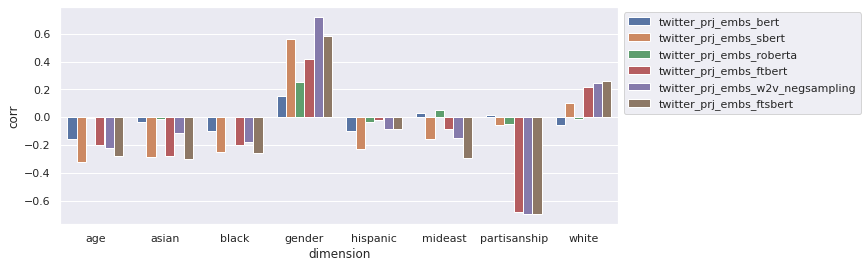

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme()

plt.figure(figsize=(10,4))
ax = sns.barplot(data=final_df, x='dimension', y='corr', hue='model')
ax.legend(bbox_to_anchor=(1, 1))
plt.show()


### load models

In [ ]:
print(twitter_prj_embs_bert["maga"], twitter_prj_embs_bert["biden"])
print(twitter_prj_embs_ftsbert["maga"], twitter_prj_embs_ftsbert["biden"])
print(twitter_prj_embs_ftsbert["senior citizen"], twitter_prj_embs_ftsbert["bitchy"])
print(twitter_prj_embs_bert["senior citizen"], twitter_prj_embs_bert["bitchy"])
print(twitter_prj_embs_bert["obama"], twitter_prj_embs_bert["trump"])
print(twitter_prj_embs_ftsbert["biden"], twitter_prj_embs_ftsbert["trump"])

### calculate metrics

In [42]:
%%time
import torch
from tqdm import tqdm
from torch.nn.functional import log_softmax



def normalize(word_vectors):
    norms = torch.norm(word_vectors, dim=1, keepdim=True)
    res = word_vectors / (norms + 1e-6)
    return res

def calculate_prj_metrics(prj_model, dataset, cosine_bs=512):
    print("calculating embeddings...")
    X, ys = zip(*dataset)

    pi_list = list(set(ys))
    pi_dict = {}
    for pi in pi_list:
        pi_dict[pi] = len(pi_dict)
        
    
    emb_x = torch.tensor([prj_model[x] for x in X])
    emb_all = torch.tensor([prj_model[y] for y in pi_list])

    emb_x = normalize(emb_x)
    emb_all = normalize(emb_all)
    
    print("calculating ranks...")
    
    i = 0
    pbar = tqdm(total=emb_x.shape[0])

    target_ranks = []
    softmax_scores = []
    
    while i < emb_x.shape[0]:
        batch = emb_x[i:i+cosine_bs]
        batch_y = ys[i:i+cosine_bs]
        batch_cosine_scores = util.cos_sim(batch.to(device), emb_all.to(device))
        batch_softmax = log_softmax(batch_cosine_scores, dim=1)
        ranks = torch.argsort(torch.argsort(batch_cosine_scores, dim=1, descending=True), dim=1)
        target_idxs = torch.tensor([pi_dict[y] for y in batch_y], dtype=torch.int64, device=device)
        
        batch_target_ranks = torch.gather(ranks, 1, target_idxs.unsqueeze(1).reshape(-1,1)).type(torch.FloatTensor)
        batch_target_scores = torch.gather(batch_softmax, 1, target_idxs.unsqueeze(1).reshape(-1,1)).type(torch.FloatTensor)
        
        target_ranks.append(batch_target_ranks)
        softmax_scores.append(batch_target_scores)
        
        i += cosine_bs
        pbar.update(cosine_bs)


    target_ranks = torch.concat(target_ranks)
    softmax_scores = torch.concat(softmax_scores)
    
    avg_score = torch.mean(softmax_scores).item()
    avg_rank = torch.mean(target_ranks).item()
    top100_acc = len([r for r in target_ranks.reshape(1,-1).squeeze().tolist() if r < len(pi_dict)//100])/emb_x.shape[0]
    
    print(avg_rank, top100_acc, avg_score)
    
    return avg_rank, top100_acc, avg_score



CPU times: user 26 µs, sys: 0 ns, total: 26 µs
Wall time: 30.5 µs


In [43]:
twitter_w2v_prj_avg_rank, twitter_w2v_prj_top100acc, twitter_w2v_prj_avg_score = calculate_prj_metrics(twitter_prj_embs_w2v_negsampling, fixed_target_twitter_clm_ds)
twitter_bert_prj_avg_rank, twitter_bert_prj_top100acc, twitter_bert_prj_avg_score = calculate_prj_metrics(twitter_prj_embs_bert, fixed_target_twitter_clm_ds)
twitter_roberta_prj_avg_rank, twitter_roberta_prj_top100acc, twitter_roberta_prj_avg_score = calculate_prj_metrics(twitter_prj_embs_roberta, fixed_target_twitter_clm_ds)
twitter_sbert_prj_avg_rank, twitter_sbert_prj_top100acc, twitter_sbert_prj_avg_score = calculate_prj_metrics(twitter_prj_embs_sbert, fixed_target_twitter_clm_ds)
twitter_bertft_prj_avg_rank, twitter_bertft_prj_top100acc, twitter_bertft_prj_avg_score = calculate_prj_metrics(twitter_prj_embs_ftbert, fixed_target_twitter_clm_ds)
twitter_sbertft_prj_avg_rank, twitter_sbertft_prj_top100acc, twitter_sbertft_prj_avg_score = calculate_prj_metrics(twitter_prj_embs_ftsbert, fixed_target_twitter_clm_ds)

calculating embeddings...
calculating ranks...


100352it [00:01, 93673.15it/s]                           


5331.86767578125 0.13437 -9.514012336730957
calculating embeddings...
calculating ranks...


100352it [00:01, 97583.47it/s]                            


7762.83251953125 0.02314 -9.711689949035645
calculating embeddings...
calculating ranks...


100352it [00:01, 98576.58it/s]                            


7530.09130859375 0.01411 -9.722024917602539
calculating embeddings...
calculating ranks...


100352it [00:01, 95414.90it/s]                            


6554.21435546875 0.04553 -9.652565956115723
calculating embeddings...
calculating ranks...


100352it [00:01, 95937.35it/s]                           


4772.92041015625 0.10004 -9.478482246398926
calculating embeddings...
calculating ranks...


100352it [00:01, 96378.83it/s]                            

2442.5263671875 0.27541 -9.260104179382324


In [44]:
wiki_w2v_prj_avg_rank, wiki_w2v_prj_top100acc, wiki_w2v_prj_avg_score = calculate_prj_metrics(wiki_prj_embs_w2v_cbow, fixed_target_wiki_clm_ds)
wiki_bert_prj_avg_rank, wiki_bert_prj_top100acc, wiki_bert_prj_avg_score = calculate_prj_metrics(wiki_prj_embs_bert, fixed_target_wiki_clm_ds)
wiki_roberta_prj_avg_rank, wiki_roberta_prj_top100acc, wiki_roberta_prj_avg_score = calculate_prj_metrics(wiki_prj_embs_roberta, fixed_target_wiki_clm_ds)
wiki_sbert_prj_avg_rank, wiki_sbert_prj_top100acc, wiki_sbert_prj_avg_score = calculate_prj_metrics(wiki_prj_embs_sbert, fixed_target_wiki_clm_ds)
wiki_bertft_prj_avg_rank, wiki_bertft_prj_top100acc, wiki_bertft_prj_avg_score = calculate_prj_metrics(wiki_prj_embs_ftbert, fixed_target_wiki_clm_ds)
wiki_sbertft_prj_avg_rank, wiki_sbertft_prj_top100acc, wiki_sbertft_prj_avg_score = calculate_prj_metrics(wiki_prj_embs_ftsbert, fixed_target_wiki_clm_ds)


calculating embeddings...
calculating ranks...


165888it [00:00, 225658.46it/s]                            


3343.31640625 0.012108932146561497 nan
calculating embeddings...
calculating ranks...


165888it [00:00, 220501.41it/s]                            


3185.967041015625 0.014159249342692429 -8.83051586151123
calculating embeddings...
calculating ranks...


165888it [00:00, 223189.54it/s]                            


2854.643798828125 0.012549147309260197 -8.835498809814453
calculating embeddings...
calculating ranks...


165888it [00:00, 217073.87it/s]                            


2017.238525390625 0.041850592179849 -8.673888206481934
calculating embeddings...
calculating ranks...


165888it [00:00, 218753.72it/s]                            


1862.4869384765625 0.09263212485225655 -8.615859985351562
calculating embeddings...
calculating ranks...


165888it [00:00, 215966.64it/s]                            

580.7388305664062 0.3606025520418747 -8.198338508605957


## frequency baseline

In [ ]:
from collections import Counter
from tqdm import tqdm

def load_bios(dataset='twitter', mode='test'):
    with open(f'data/{dataset}_{mode}_bios.pkl', 'rb') as f:
        bios = pickle.load(f)
    
    return bios


def calculate_freq_ranks(dataset_name, dataset, return_ranks=False):

    bios = load_bios(dataset=dataset_name, mode='train')
    cntr = Counter()

    _, ys = zip(*dataset)
    y_set = set(ys)
    
    for bio in tqdm(bios):
        for pi in bio:
            if pi in y_set:
                cntr.update([pi])

    
    ranks_d = {item[1][0]: item[0] for item in enumerate(cntr.most_common())}
    ranks = [ranks_d[x] for x in ys]
    avg_rank = np.mean(ranks)
    top100_acc = np.sum(np.where(np.array(ranks)<=100, 1., 0.))/len(ranks)
    
    if return_ranks:
        return avg_rank, top100_acc, ranks

    return avg_rank, top100_acc
    
# twitter_freq_based_avg_rank, twitter_freq_based_top100acc, twitter_freq_based_ranks = calculate_freq_ranks('twitter', fixed_target_twitter_clm_ds, return_ranks=True)
wiki_freq_based_avg_rank, wiki_freq_based_top100acc, wiki_freq_based_ranks = calculate_freq_ranks('wiki', fixed_target_wiki_clm_ds, return_ranks=True)
# wiki_freq_based_avg_rank, wiki_freq_based_top100acc = calculate_freq_ranks('wiki', fixed_target_wiki_clm_ds)


## calculate metrics

In [10]:
%%time
import torch
from sentence_transformers import SentenceTransformer, models, util
from tqdm import tqdm
from torch.nn.functional import log_softmax



def normalize(word_vectors):
    norms = torch.norm(word_vectors, dim=1, keepdim=True)
    res = word_vectors / (norms + 1e-6)
    return res

def calculate_clm_based_metrics(clm_model, tokenizer, dataset, pi_dict,
                                default_encoder=False, device='cuda:0', average_k_layers=1,
                                cosine_bs=512, emb_bs=512, return_ranks=False):
    print("calculating embeddings...")
    pi_list = list(pi_dict.keys())
    X, ys = zip(*dataset)
    
    if default_encoder:        
        emb_x = get_sbertbased_results_batched(clm_model, X, bs=emb_bs)
        emb_all = get_sbertbased_results_batched(clm_model, pi_list, bs=emb_bs)
            
    else:
        emb_x = get_results_batched(clm_model, tokenizer, X, average_k_layers=average_k_layers, bs=emb_bs)
        emb_all = get_results_batched(clm_model, tokenizer, pi_list, average_k_layers=average_k_layers, bs=emb_bs)

    print("calculating ranks...")
    
    emb_x = normalize(emb_x)
    emb_all = normalize(emb_all)
    
    
    i = 0
    pbar = tqdm(total=emb_x.shape[0])

    target_ranks = []
    softmax_scores = []
    
    while i < emb_x.shape[0]:
        batch = emb_x[i:i+cosine_bs]
        batch_y = ys[i:i+cosine_bs]
        batch_cosine_scores = util.cos_sim(batch.to(device), emb_all.to(device))
        batch_softmax = log_softmax(batch_cosine_scores, dim=1)
#         print(torch.sum(batch_softmax, dim=1), torch.sum(batch_softmax, dim=1).shape)
        ranks = torch.argsort(torch.argsort(batch_cosine_scores, dim=1, descending=True), dim=1)
        target_idxs = torch.tensor([pi_dict[y] for y in batch_y], dtype=torch.int64, device=device)
        
        batch_target_ranks = torch.gather(ranks, 1, target_idxs.unsqueeze(1).reshape(-1,1)).type(torch.FloatTensor)
        batch_target_scores = torch.gather(batch_softmax, 1, target_idxs.unsqueeze(1).reshape(-1,1)).type(torch.FloatTensor)
        
        target_ranks.append(batch_target_ranks)
        softmax_scores.append(batch_target_scores)
        
        i += cosine_bs
        pbar.update(cosine_bs)


    target_ranks = torch.concat(target_ranks)
    softmax_scores = torch.concat(softmax_scores)
    
#     print(softmax_scores)

    avg_score = torch.mean(softmax_scores).item()
    avg_rank = torch.mean(target_ranks).item()
#     
    top100_acc = len([r for r in target_ranks.reshape(1,-1).squeeze().tolist() if r < len(pi_list)//100])/emb_x.shape[0]
    
    print(avg_rank, top100_acc, avg_score)
    
    if return_ranks:
        return avg_rank, top100_acc, avg_score, target_ranks.tolist()
    return avg_rank, top100_acc, avg_score

CPU times: user 19 µs, sys: 0 ns, total: 19 µs
Wall time: 21.7 µs


### twitter restricted target experiments

In [11]:
%%time

# sbert and its finetuned
twitter_sbertft_avg_rank, twitter_sbertft_top100acc, twitter_sbertft_avg_score, twitter_sbertft_ranks = calculate_clm_based_metrics(
    clm_model=twitter_ft_sbert,
    tokenizer=None,
    dataset=fixed_target_twitter_clm_ds,
    pi_dict=twitter_target_restricted_pis,
    default_encoder=True,
    return_ranks=True,
)

# twitter_sbertft10_avg_rank, twitter_sbertft10_top100acc, twitter_sbertft10_avg_score, twitter_sbertft10_ranks = calculate_clm_based_metrics(
#     clm_model=twitter_ft_sbert_10p,
#     tokenizer=None,
#     dataset=fixed_target_twitter_clm_ds,
#     pi_dict=twitter_target_restricted_pis,
#     default_encoder=True,
#     return_ranks=True,
# )

# twitter_sbert_avg_rank, twitter_sbert_top100acc, twitter_sbert_avg_score, twitter_sbert_ranks =  calculate_clm_based_metrics(
#     clm_model=sbert_model,
#     tokenizer=None,
#     dataset=fixed_target_twitter_clm_ds,
#     pi_dict=twitter_target_restricted_pis,
#     default_encoder=True,
#     return_ranks=True,
# )

# bert and roberta

# twitter_bert_avg_rank, twitter_bert_top100acc, twitter_bert_avg_score, twitter_bert_ranks = calculate_clm_based_metrics(
#     clm_model=bert_model,
#     tokenizer=bert_tokenizer,
#     dataset=fixed_target_twitter_clm_ds,
#     pi_dict=twitter_target_restricted_pis,
#     default_encoder=False,
#     return_ranks=True,
#     average_k_layers=1
# )

# twitter_roberta_avg_rank, twitter_roberta_top100acc, twitter_roberta_avg_score, twitter_roberta_ranks =  calculate_clm_based_metrics(
#     clm_model=roberta_model,
#     tokenizer=roberta_tokenizer,
#     dataset=fixed_target_twitter_clm_ds,
#     pi_dict=twitter_target_restricted_pis,
#     default_encoder=False,
#     return_ranks=True,
#     average_k_layers=1
# )

# twitter_bertft_avg_rank, twitter_bertft_top100acc, twitter_bertft_avg_score, twitter_bertft_ranks =  calculate_clm_based_metrics(
#     clm_model=bert_ft_twitter_model,
#     tokenizer=bert_ft_tokenizer,
#     dataset=fixed_target_twitter_clm_ds,
#     pi_dict=twitter_target_restricted_pis,
#     default_encoder=False,
#     return_ranks=True,
#     average_k_layers=1
# )

# twitter_bertft50_avg_rank, twitter_bertft50_top100acc, twitter_bertft50_avg_score, twitter_bertft50_ranks =  calculate_clm_based_metrics(
#     clm_model=bert_ft50_twitter_model,
#     tokenizer=bert_ft_tokenizer,
#     dataset=fixed_target_twitter_clm_ds,
#     pi_dict=twitter_target_restricted_pis,
#     default_encoder=False,
#     return_ranks=True,
#     average_k_layers=1
# )

# twitter_bertftlarge_avg_rank, twitter_bertftlarge_top100acc, twitter_bertftlarge_avg_score, twitter_bertftlarge_ranks =  calculate_clm_based_metrics(
#     clm_model=bertlarge_ft_twitter_model,
#     tokenizer=bertlarge_ft_tokenizer,
#     dataset=fixed_target_twitter_clm_ds,
#     pi_dict=twitter_target_restricted_pis,
#     default_encoder=False,
#     return_ranks=True,
#     average_k_layers=1
# )


calculating embeddings...


100352it [00:57, 1747.06it/s]                           
22528it [00:06, 3295.32it/s]                           


calculating ranks...


100352it [00:03, 29692.57it/s]                           

1556.8677978515625 0.46216 -9.599580764770508
CPU times: user 1min 31s, sys: 16.7 s, total: 1min 48s
Wall time: 1min 7s


## wiki restricted target experiments

In [ ]:
%%time

# sbert and its finetuned
wiki_sbertft_avg_rank, wiki_sbertft_top100acc, wiki_sbertft_avg_score, wiki_sbertft_ranks = calculate_clm_based_metrics(
    clm_model=wiki_ft_sbert,
    tokenizer=None,
    dataset=fixed_target_wiki_clm_ds,
    pi_dict=wiki_target_restricted_pis,
    default_encoder=True,
    return_ranks=True,
)

wiki_sbert_avg_rank, wiki_sbert_top100acc, wiki_sbert_avg_score, wiki_sbert_ranks =  calculate_clm_based_metrics(
    clm_model=sbert_model,
    tokenizer=None,
    dataset=fixed_target_wiki_clm_ds,
    pi_dict=wiki_target_restricted_pis,
    default_encoder=True,
    return_ranks=True,
)

# bert and roberta

wiki_bert_avg_rank, wiki_bert_top100acc, wiki_bert_avg_score, wiki_bert_ranks = calculate_clm_based_metrics(
    clm_model=bert_model,
    tokenizer=bert_tokenizer,
    dataset=fixed_target_wiki_clm_ds,
    pi_dict=wiki_target_restricted_pis,
    default_encoder=False,
    return_ranks=True,
    average_k_layers=1
)

wiki_roberta_avg_rank, wiki_roberta_top100acc, wiki_roberta_avg_score, wiki_roberta_ranks =  calculate_clm_based_metrics(
    clm_model=roberta_model,
    tokenizer=roberta_tokenizer,
    dataset=fixed_target_wiki_clm_ds,
    pi_dict=wiki_target_restricted_pis,
    default_encoder=False,
    return_ranks=True,
    average_k_layers=1
)

wiki_bertft_avg_rank, wiki_bertft_top100acc, wiki_bertft_avg_score, wiki_bertft_ranks =  calculate_clm_based_metrics(
    clm_model=bert_ft_wiki_model,
    tokenizer=bert_ft_tokenizer,
    dataset=fixed_target_wiki_clm_ds,
    pi_dict=wiki_target_restricted_pis,
    default_encoder=False,
    return_ranks=True,
    average_k_layers=1
)


### full bio metrics

In [ ]:
%%time
# sbert and its finetuned

twitter_sbertft_avg_rank, twitter_sbertft_top100acc = calculate_clm_based_metrics(
    clm_model=twitter_ft_sbert,
    tokenizer=None,
    dataset=clm_test_ds_twitter,
    pi_dict=twitter_pi_dict,
    default_encoder=True
)

twitter_sbert_avg_rank, twitter_sbert_top100acc =  calculate_clm_based_metrics(
    clm_model=sbert_model,
    tokenizer=None,
    dataset=clm_test_ds_twitter,
    pi_dict=twitter_pi_dict,
    default_encoder=True
)

wiki_sbertft_avg_rank, wiki_sbertft_top100acc =  calculate_clm_based_metrics(
    clm_model=wiki_ft_sbert,
    tokenizer=None,
    dataset=clm_test_ds_wiki,
    pi_dict=wiki_pi_dict,
    default_encoder=True
)

wiki_sbert_avg_rank, wiki_sbert_top100acc =  calculate_clm_based_metrics(
    clm_model=sbert_model,
    tokenizer=None,
    dataset=clm_test_ds_wiki,
    pi_dict=wiki_pi_dict,
    default_encoder=True
)

# bert and bertweet

twitter_bert_avg_rank, twitter_bert_top100acc = calculate_clm_based_metrics(
    clm_model=bert_model,
    tokenizer=bert_tokenizer,
    dataset=clm_test_ds_twitter,
    pi_dict=twitter_pi_dict,
    default_encoder=False
)

twitter_bertweet_avg_rank, twitter_bertweet_top100acc =  calculate_clm_based_metrics(
    clm_model=bertweet_model,
    tokenizer=bertweet_tokenizer,
    dataset=clm_test_ds_twitter,
    pi_dict=twitter_pi_dict,
    default_encoder=False
)

wiki_bert_avg_rank, wiki_bert_top100acc = calculate_clm_based_metrics(
    clm_model=bert_model,
    tokenizer=bert_tokenizer,
    dataset=clm_test_ds_wiki,
    pi_dict=wiki_pi_dict,
    default_encoder=False
)

wiki_bertweet_avg_rank, wiki_bertweet_top100acc =  calculate_clm_based_metrics(
    clm_model=bertweet_model,
    tokenizer=bertweet_tokenizer,
    dataset=clm_test_ds_wiki,
    pi_dict=wiki_pi_dict,
    default_encoder=False
)

### random pi in bio metrics

In [ ]:
%%time
# sbert and its finetuned

twitterrand_sbertft_avg_rank, twitterrand_sbertft_top100acc = calculate_clm_based_metrics(
    clm_model=twitter_ft_sbert,
    tokenizer=None,
    dataset=clm_test_ds_twitter_rand,
    pi_dict=twitter_pi_dict,
    default_encoder=True
)

twitterrand_sbert_avg_rank, twitterrand_sbert_top100acc =  calculate_clm_based_metrics(
    clm_model=sbert_model,
    tokenizer=None,
    dataset=clm_test_ds_twitter_rand,
    pi_dict=twitter_pi_dict,
    default_encoder=True
)

wikirand_sbertft_avg_rank, wikirand_sbertft_top100acc =  calculate_clm_based_metrics(
    clm_model=wiki_ft_sbert,
    tokenizer=None,
    dataset=clm_test_ds_wiki_rand,
    pi_dict=wiki_pi_dict,
    default_encoder=True
)

wikirand_sbert_avg_rank, wikirand_sbert_top100acc =  calculate_clm_based_metrics(
    clm_model=sbert_model,
    tokenizer=None,
    dataset=clm_test_ds_wiki_rand,
    pi_dict=wiki_pi_dict,
    default_encoder=True
)

# bert and bertweet

twitterrand_bert_avg_rank, twitterrand_bert_top100acc = calculate_clm_based_metrics(
    clm_model=bert_model,
    tokenizer=bert_tokenizer,
    dataset=clm_test_ds_twitter_rand,
    pi_dict=twitter_pi_dict,
    default_encoder=False
)

twitterrand_bertweet_avg_rank, twitterrand_bertweet_top100acc =  calculate_clm_based_metrics(
    clm_model=bertweet_model,
    tokenizer=bertweet_tokenizer,
    dataset=clm_test_ds_twitter_rand,
    pi_dict=twitter_pi_dict,
    default_encoder=False
)

wikirand_bert_avg_rank, wikirand_bert_top100acc = calculate_clm_based_metrics(
    clm_model=bert_model,
    tokenizer=bert_tokenizer,
    dataset=clm_test_ds_wiki_rand,
    pi_dict=wiki_pi_dict,
    default_encoder=False
)

wikirand_bertweet_avg_rank, wikirand_bertweet_top100acc =  calculate_clm_based_metrics(
    clm_model=bertweet_model,
    tokenizer=bertweet_tokenizer,
    dataset=clm_test_ds_wiki_rand,
    pi_dict=wiki_pi_dict,
    default_encoder=False
)

### non restricted test dataset

In [ ]:

twitter_bert_avg_rank, twitter_bert_top100acc = calculate_clm_based_metrics(
    clm_model=bert_model,
    tokenizer=bert_tokenizer,
    dataset=clm_test_ds_full_twitter,
    pi_dict=twitter_pi_dict_full,
    default_encoder=False,
    emb_bs=512,
    cosine_bs=512
)

wiki_bert_avg_rank, wiki_bert_top100acc = calculate_clm_based_metrics(
    clm_model=bert_model,
    tokenizer=bert_tokenizer,
    dataset=clm_test_ds_full_wiki,
    pi_dict=wiki_pi_dict_full,
    default_encoder=False,
    emb_bs=512,
    cosine_bs=512
)

In [ ]:
twitter_bertweet_avg_rank, twitter_bertweet_top100acc =  calculate_clm_based_metrics(
    clm_model=bertweet_model,
    tokenizer=bertweet_tokenizer,
    dataset=clm_test_ds_full_twitter,
    pi_dict=twitter_pi_dict_full,
    default_encoder=False,
    emb_bs=512,
    cosine_bs=512
)

wiki_bertweet_avg_rank, wiki_bertweet_top100acc =  calculate_clm_based_metrics(
    clm_model=bertweet_model,
    tokenizer=bertweet_tokenizer,
    dataset=clm_test_ds_full_wiki,
    pi_dict=wiki_pi_dict_full,
    default_encoder=False,
    emb_bs=512,
    cosine_bs=512
)

In [ ]:

twitter_sbertft_avg_rank, twitter_sbertft_top100acc = calculate_clm_based_metrics(
    clm_model=twitter_ft_sbert,
    tokenizer=None,
    dataset=clm_test_ds_full_twitter,
    pi_dict=twitter_pi_dict_full,
    default_encoder=True,
    emb_bs=512,
    cosine_bs=512
)

twitter_sbert_avg_rank, twitter_sbert_top100acc =  calculate_clm_based_metrics(
    clm_model=sbert_model,
    tokenizer=None,
    dataset=clm_test_ds_full_twitter,
    pi_dict=twitter_pi_dict_full,
    default_encoder=True,
    emb_bs=512,
    cosine_bs=512
)

wiki_sbertft_avg_rank, wiki_sbertft_top100acc =  calculate_clm_based_metrics(
    clm_model=wiki_ft_sbert,
    tokenizer=None,
    dataset=clm_test_ds_full_wiki,
    pi_dict=wiki_pi_dict_full,
    default_encoder=True,
    emb_bs=512,
    cosine_bs=512
)

wiki_sbert_avg_rank, wiki_sbert_top100acc =  calculate_clm_based_metrics(
    clm_model=sbert_model,
    tokenizer=None,
    dataset=clm_test_ds_full_wiki,
    pi_dict=wiki_pi_dict_full,
    default_encoder=True,
    emb_bs=512,
    cosine_bs=512
)


### cross platform models

In [ ]:

twitter_crossplt_sbertft_avg_rank, twitter_crossplt_sbertft_top100acc = calculate_clm_based_metrics(
    clm_model=wiki_ft_sbert,
    tokenizer=None,
    dataset=clm_test_ds_full_twitter,
    pi_dict=twitter_pi_dict_full,
    default_encoder=True,
    emb_bs=512,
    cosine_bs=512
)


wiki_crossplt_sbertft_avg_rank, wiki_crossplt_sbertft_top100acc =  calculate_clm_based_metrics(
    clm_model=twitter_ft_sbert,
    tokenizer=None,
    dataset=clm_test_ds_full_wiki,
    pi_dict=wiki_pi_dict_full,
    default_encoder=True,
    emb_bs=512,
    cosine_bs=512
)


## Full comparison

### twitter only

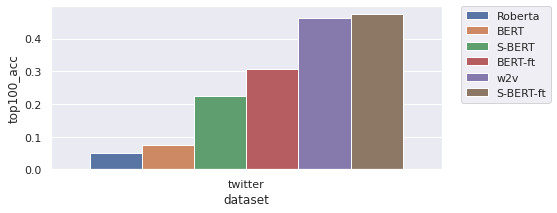

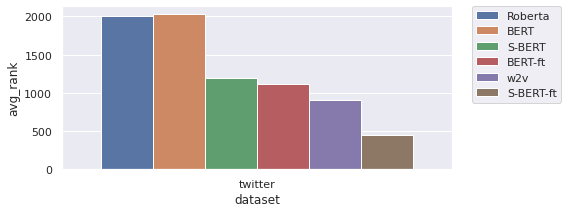

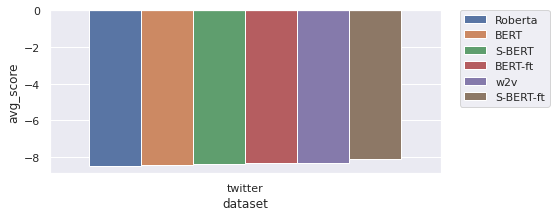

In [43]:
import seaborn as sns

sns.set_theme()

import matplotlib.pyplot as plt
import pandas as pd

df = pd.DataFrame({
    'model': [
        'Roberta',
        'BERT',
        'S-BERT',
        'BERT-ft',
        'w2v',
        'S-BERT-ft',
    ],
    'dataset': [
        'twitter',
        'twitter',
        'twitter',
        'twitter',
        'twitter',
        'twitter',
    ],
    'avg_rank': [
        twitter_roberta_avg_rank,
        twitter_bert_avg_rank,
        twitter_sbert_avg_rank,
        twitter_bertft_avg_rank,
        twitter_w2v_negsample_avgrank,         
        twitter_sbertft_avg_rank,
    ],
    'avg_score': [
        twitter_roberta_avg_score,
        twitter_bert_avg_score,
        twitter_sbert_avg_score,
        twitter_bertft_avg_score,
        twitter_w2v_negsample_avgscore,         
        twitter_sbertft_avg_score,
    ],
    'top100_acc': [
        twitter_roberta_top100acc,
        twitter_bert_top100acc,
        twitter_sbert_top100acc,
        twitter_bertft_top100acc,
        twitter_w2v_negsample_top100acc,
        twitter_sbertft_top100acc,
    ],
})

df.to_csv('performance_twitter_f500.csv', header=True, index=False)

plt.figure(figsize=(7,3))
sns.barplot(data=df, x='dataset', y='top100_acc', hue='model')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.show()

plt.figure(figsize=(7,3))
sns.barplot(data=df, x='dataset', y='avg_rank', hue='model')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.show()

plt.figure(figsize=(7,3))
sns.barplot(data=df, x='dataset', y='avg_score', hue='model')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.show()

### twitter vs wiki - projection

In [ ]:
twitter_w2v_prj_avg_rank, twitter_w2v_prj_top100acc, twitter_w2v_prj_avg_score

import seaborn as sns

sns.set_theme()

import matplotlib.pyplot as plt
import pandas as pd

df = pd.DataFrame({
    'model': [
        'w2v',
        'w2v',
        'BERT',
        'BERT',
        'S-BERT',
        'S-BERT',
        'Roberta',
        'Roberta',
        'S-BERT-ft',
        'S-BERT-ft',
        'BERT-ft',
        'BERT-ft'
    ],
    'dataset': [
        'twitter',
        'wiki',
        'twitter',
        'wiki',
        'twitter',
        'wiki',
        'twitter',
        'wiki',
        'twitter',
        'wiki',
        'twitter',
        'wiki',
    ],
    'avg_rank': [
        twitter_w2v_prj_avg_rank, 
        wiki_w2v_prj_avg_rank,
        twitter_bert_prj_avg_rank, 
        wiki_bert_prj_avg_rank,
        twitter_sbert_prj_avg_rank, 
        wiki_sbert_prj_avg_rank,
        twitter_roberta_prj_avg_rank, 
        wiki_roberta_prj_avg_rank,
        twitter_sbertft_prj_avg_rank, 
        wiki_sbertft_prj_avg_rank,
        twitter_bertft_prj_avg_rank, 
        wiki_bertft_prj_avg_rank,
    ],
    'avg_score': [
        twitter_w2v_prj_avg_score, 
        wiki_w2v_prj_avg_score,
        twitter_bert_prj_avg_score, 
        wiki_bert_prj_avg_score,
        twitter_sbert_prj_avg_score, 
        wiki_sbert_prj_avg_score,
        twitter_roberta_prj_avg_score,
        wiki_roberta_prj_avg_score,
        twitter_sbertft_prj_avg_score, 
        wiki_sbertft_prj_avg_score,
        twitter_bertft_prj_avg_score, 
        wiki_bertft_prj_avg_score,
    ],
    'top100_acc': [
        twitter_w2v_prj_top100acc, 
        wiki_w2v_prj_top100acc,
        twitter_bert_prj_top100acc, 
        wiki_bert_prj_top100acc,
        twitter_sbert_prj_top100acc, 
        wiki_sbert_prj_top100acc,
        twitter_roberta_prj_top100acc,
        wiki_roberta_prj_top100acc,
        twitter_sbertft_prj_top100acc, 
        wiki_sbertft_prj_top100acc,
        twitter_bertft_prj_top100acc, 
        wiki_bertft_prj_top100acc,
    ],
})

df.to_csv('projection_final_results.csv', header=True, index=False)

plt.figure(figsize=(7,3))
sns.barplot(data=df, x='dataset', y='top100_acc', hue='model')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.show()

plt.figure(figsize=(7,3))
sns.barplot(data=df, x='dataset', y='avg_rank', hue='model')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.show()

plt.figure(figsize=(7,3))
sns.barplot(data=df, x='dataset', y='avg_score', hue='model')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.show()

### twitter vs wiki

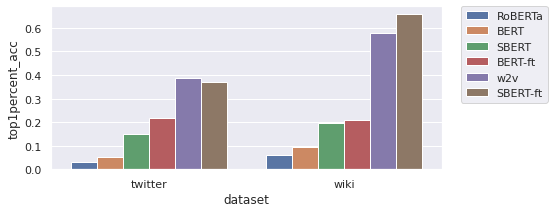

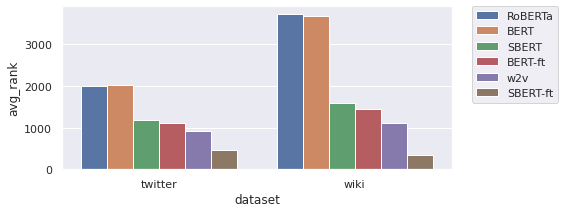

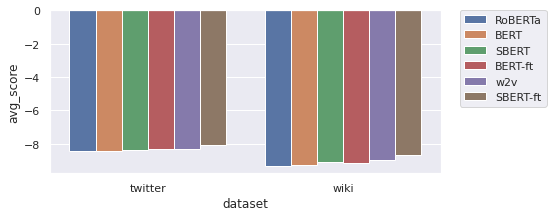

In [51]:
import seaborn as sns

sns.set_theme()

import matplotlib.pyplot as plt
import pandas as pd

df = pd.DataFrame({
    'model': [
        'RoBERTa',
        'RoBERTa',
        'BERT',
        'BERT',
        'SBERT',
        'SBERT',
        'BERT-ft',
        'BERT-ft',
        'w2v',
        'w2v',
        'SBERT-ft',
        'SBERT-ft',
    ],
    'dataset': [
        'twitter',
        'wiki',
        'twitter',
        'wiki',
        'twitter',
        'wiki',
        'twitter',
        'wiki',
        'twitter',
        'wiki',
        'twitter',
        'wiki',
    ],
    'avg_rank': [
        twitter_roberta_avg_rank,
        wiki_roberta_avg_rank,
        
        twitter_bert_avg_rank,
        wiki_bert_avg_rank,
        twitter_sbert_avg_rank,
        wiki_sbert_avg_rank,
        
        twitter_bertft_avg_rank,
        wiki_bertft_avg_rank,
        
        twitter_w2v_negsample_avgrank, 
        wiki_w2v_cbow_avgrank,
        twitter_sbertft_avg_rank,
        wiki_sbertft_avg_rank,
    ],
    'avg_score': [
        twitter_roberta_avg_score,
        wiki_roberta_avg_score,
        
        twitter_bert_avg_score,
        wiki_bert_avg_score,
        twitter_sbert_avg_score,
        wiki_sbert_avg_score,
        
        twitter_bertft_avg_score,
        wiki_bertft_avg_score,
        
        twitter_w2v_negsample_avgscore, 
        wiki_w2v_cbow_avgscore,
        twitter_sbertft_avg_score,
        wiki_sbertft_avg_score,
    ],
    'top1percent_acc': [
        twitter_roberta_top100acc,
        wiki_roberta_top100acc,
        
        twitter_bert_top100acc,
        wiki_bert_top100acc,
        twitter_sbert_top100acc,
        wiki_sbert_top100acc,
        
        twitter_bertft_top100acc,
        wiki_bertft_top100acc,
        
        twitter_w2v_negsample_top100acc,
        wiki_w2v_cbow_top100acc,
        twitter_sbertft_top100acc,
        wiki_sbertft_top100acc,
    ],
})

df.to_csv('final_performance_results_f500.csv', header=True, index=False)

plt.figure(figsize=(7,3))
sns.barplot(data=df, x='dataset', y='top1percent_acc', hue='model')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.show()

plt.figure(figsize=(7,3))
sns.barplot(data=df, x='dataset', y='avg_rank', hue='model')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.show()

plt.figure(figsize=(7,3))
sns.barplot(data=df, x='dataset', y='avg_score', hue='model')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.show()

In [ ]:
import seaborn as sns

sns.set_theme()

import matplotlib.pyplot as plt
import pandas as pd

df = pd.DataFrame({
    'model': [
        'w2v',
        'w2v',
        'BERT',
        'BERT',
        'S-BERT',
        'S-BERT',
        'BerTweet',
        'BerTweet',
        'S-BERT-ft',
        'S-BERT-ft',
    ],
    'dataset': [
        'twitter',
        'wiki',
        'twitter',
        'wiki',
        'twitter',
        'wiki',
        'twitter',
        'wiki',
        'twitter',
        'wiki',
    ],
    'avg_rank': [
        twitterrand_w2v_negsample_avgrank,
        wiki_w2v_cbow_avgrank,
        wikirand_w2v_cbow_avgrank,
        twitterrand_bert_avg_rank,
        wikirand_bert_avg_rank,
        twitterrand_sbert_avg_rank,
        wikirand_sbert_avg_rank,
        twitterrand_bertweet_avg_rank,
        wikirand_bertweet_avg_rank,
        twitterrand_sbertft_avg_rank,
        wikirand_sbertft_avg_rank,
    ],
    'top100_acc': [
        twitterrand_w2v_negsample_top100acc,
        wiki_w2v_cbow_top100acc
        wikirand_w2v_cbow_top100acc,
        twitterrand_bert_top100acc,
        wikirand_bert_top100acc,
        twitterrand_sbert_top100acc,
        wikirand_sbert_top100acc,
        twitterrand_bertweet_top100acc,
        wikirand_bertweet_top100acc,
        twitterrand_sbertft_top100acc,
        wikirand_sbertft_top100acc,
    ],
})

df.to_csv('result_restricted_randombio.csv', header=True, index=False)

sns.barplot(data=df, x='dataset', y='top100_acc', hue='model')
plt.show()

sns.barplot(data=df, x='dataset', y='avg_rank', hue='model')
plt.show()

### twitter generalization

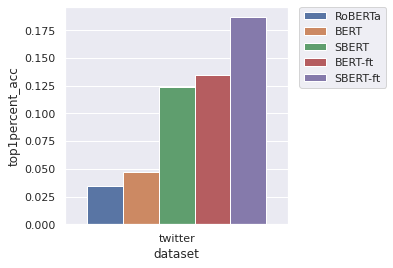

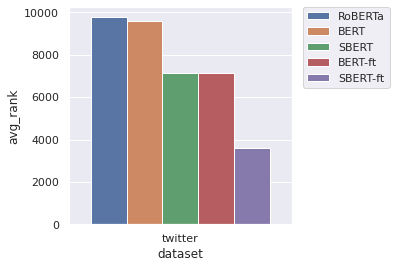

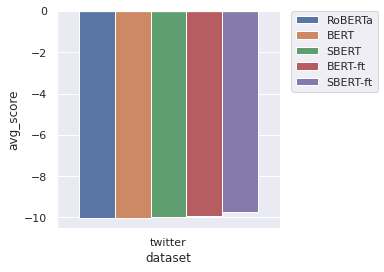

In [82]:
import seaborn as sns

sns.set_theme()

import matplotlib.pyplot as plt
import pandas as pd

df = pd.DataFrame({
    'model': [
        'RoBERTa',
        'BERT',
        'SBERT',
        'BERT-ft',
        'SBERT-ft',
    ],
    'dataset': [
        'twitter',
        'twitter',
        'twitter',
        'twitter',
        'twitter',
    ],
    'avg_rank': [
        twitter_roberta_avg_rank,
        
        twitter_bert_avg_rank,
        twitter_sbert_avg_rank,
        
        twitter_bertft_avg_rank,
        
        twitter_sbertft_avg_rank,
    ],
    'avg_score': [
        twitter_roberta_avg_score,

        twitter_bert_avg_score,

        twitter_sbert_avg_score,
        twitter_bertft_avg_score,
        
        
        twitter_sbertft_avg_score,
    ],
    'top1percent_acc': [
        twitter_roberta_top100acc,
        
        twitter_bert_top100acc,
        twitter_sbert_top100acc,
        
        twitter_bertft_top100acc,
        
        twitter_sbertft_top100acc,
    ],
})

df.to_csv('final_generalization_performance_results.csv', header=True, index=False)

plt.figure(figsize=(4,4))
sns.barplot(data=df, x='dataset', y='top1percent_acc', hue='model')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.show()

plt.figure(figsize=(4,4))
sns.barplot(data=df, x='dataset', y='avg_rank', hue='model')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.show()


# df['avg_score'] = (df['avg_score'] - min(df['avg_score'])) / (max(df['avg_score']) - min(df['avg_score']))
plt.figure(figsize=(4,4))
sns.barplot(data=df, x='dataset', y='avg_score', hue='model')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.show()

In [83]:
gen_df = df.copy()
gen_df['dataset'] = 'twitter-generalization'
gen_df

,model,dataset,avg_rank,avg_score,top1percent_acc
0,RoBERTa,twitter-generalization,9771.505859,-10.021909,0.03491
1,BERT,twitter-generalization,9580.711914,-10.010970,0.04689
2,SBERT,twitter-generalization,7136.857422,-9.955600,0.12339
3,BERT-ft,twitter-generalization,7131.043945,-9.931478,0.13479
4,SBERT-ft,twitter-generalization,3620.277832,-9.755762,0.18677


In [84]:
df = pd.read_csv('final_performance_results.csv')
# df = df[df.model!='w2v']
df = df[df.dataset != 'wiki']
df


,model,dataset,avg_rank,avg_score,top1percent_acc
0,RoBERTa,twitter,9271.075195,-10.021880,0.03525
2,BERT,twitter,9611.648438,-10.011054,0.05112
4,SBERT,twitter,5606.247559,-9.928705,0.15891
6,BERT-ft,twitter,4450.077148,-9.863602,0.25423
8,w2v,twitter,4148.187988,-9.891065,0.43201
10,SBERT-ft,twitter,1543.439819,-9.598256,0.46429


In [85]:
res_df = pd.concat([gen_df, df], axis=0)
res_df = res_df[res_df.model!='w2v']
res_df

,model,dataset,avg_rank,avg_score,top1percent_acc
0,RoBERTa,twitter-generalization,9771.505859,-10.021909,0.03491
1,BERT,twitter-generalization,9580.711914,-10.010970,0.04689
2,SBERT,twitter-generalization,7136.857422,-9.955600,0.12339
3,BERT-ft,twitter-generalization,7131.043945,-9.931478,0.13479
4,SBERT-ft,twitter-generalization,3620.277832,-9.755762,0.18677
0,RoBERTa,twitter,9271.075195,-10.021880,0.03525
2,BERT,twitter,9611.648438,-10.011054,0.05112
4,SBERT,twitter,5606.247559,-9.928705,0.15891
6,BERT-ft,twitter,4450.077148,-9.863602,0.25423
10,SBERT-ft,twitter,1543.439819,-9.598256,0.46429


In [92]:
res_df = res_df[res_df.dataset == 'twitter-generalization']
res_df['avg_score'] = (res_df['avg_score'] - min(res_df['avg_score'])) / (max(res_df['avg_score']) - min(res_df['avg_score']))

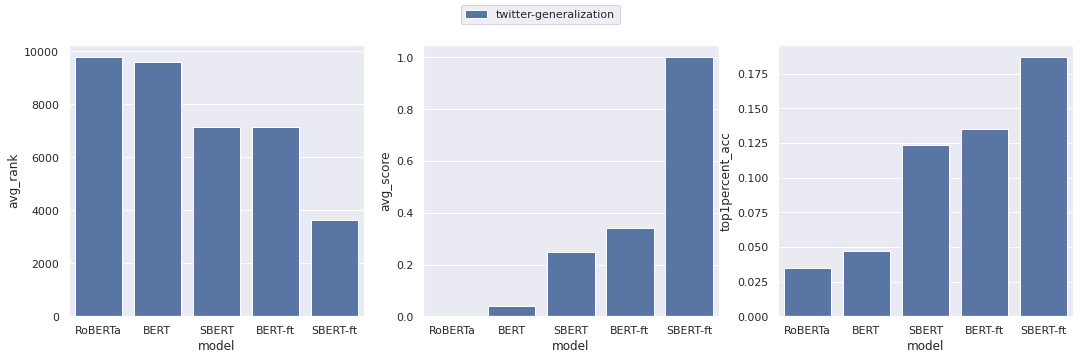

In [93]:
fig, ax = plt.subplots(1, 3, figsize=(18,5))

g = sns.barplot(data=res_df, x='model', y='avg_rank', hue='dataset', ax=ax[0])
# g.axhline(df[df.model=='w2v']['avg_rank'].item(), color='r')
g.legend_.remove()

g = sns.barplot(data=res_df, x='model', y='avg_score', hue='dataset', ax=ax[1])
# g.axhline(df[df.model=='w2v']['avg_score'].item(), color='r')
g.legend_.remove()

g = sns.barplot(data=res_df, x='model', y='top1percent_acc', hue='dataset', ax=ax[2])
# g.axhline(df[df.model=='w2v']['top1percent_acc'].item(), color='r')
g.legend_.remove()

handles, labels = ax[2].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center')
# plt.legend(bbox_to_anchor=(1.05, 1), loc='upper right', borderaxespad=0)
plt.show()

### restricted target results for wiki

In [ ]:
import seaborn as sns

sns.set_theme()

import matplotlib.pyplot as plt
import pandas as pd

df = pd.DataFrame({
    'model': [
        'w2v',
        'bert',
        'roberta',
        'bert-ft',
        'sbert',
        'sbert-ft'
    ],
    'dataset': [
        'wiki',
        'wiki',
        'wiki',
        'wiki',
        'wiki',
        'wiki',
    ],
    'avg_rank': [
        wiki_w2v_cbow_avgrank, 
        wiki_bert_avg_rank,
        wiki_roberta_avg_rank,
        wiki_bertft_avg_rank,
        wiki_sbert_avg_rank,
        wiki_sbertft_avg_rank,
    ],
    'avg_score': [
        wiki_w2v_cbow_avgscore, 
        wiki_bert_avg_score,
        wiki_roberta_avg_score,
        wiki_bertft_avg_score,
        wiki_sbert_avg_score,
        wiki_sbertft_avg_score,
    ],
    'top100_acc': [
        wiki_w2v_cbow_top100acc, 
        wiki_bert_top100acc,
        wiki_roberta_top100acc,
        wiki_bertft_top100acc,
        wiki_sbert_top100acc,
        wiki_sbertft_top100acc,
    ],
})

df.to_csv('wiki_final_results.csv', header=True, index=False)

plt.figure(figsize=(4,4))
sns.barplot(data=df, x='dataset', y='top100_acc', hue='model')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.show()

plt.figure(figsize=(4,4))
sns.barplot(data=df, x='dataset', y='avg_rank', hue='model')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.show()


df['avg_score'] = (df['avg_score'] - min(df['avg_score'])) / (max(df['avg_score']) - min(df['avg_score']))
plt.figure(figsize=(4,4))
sns.barplot(data=df, x='dataset', y='avg_score', hue='model')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.show()

## freq vs ranks

In [16]:
import pickle

with open('data/twitter_cleaned_train_bios_100.pkl', 'rb') as f:
    twitter_bios = pickle.load(f)

twitter_cntr = Counter()

_, twitter_ys = zip(*fixed_target_twitter_clm_ds)
y_set = set(twitter_ys)

for bio in tqdm(twitter_bios):
    for pi in bio:
        if pi in y_set:
            twitter_cntr.update([pi])

    
# with open('data/wiki_cleaned_train_bios_3.pkl', 'rb') as f:
#     wiki_bios = pickle.load(f)
    
# wiki_cntr = Counter()

# _, wiki_ys = zip(*fixed_target_wiki_clm_ds)
# y_set = set(wiki_ys)

# for bio in tqdm(wiki_bios):
#     for pi in bio:
#         if pi in y_set:
#             wiki_cntr.update([pi])

100%|██████████| 3534903/3534903 [00:12<00:00, 290929.78it/s]


In [17]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pickle

sns.set_theme()

def plot_rank_freq(ranks, ys, counter, name, order=1):
    if isinstance(ranks[0], list):
        ranks = [r[0] for r in ranks]
    
    data = np.array(list(zip(ranks, ys)))
    sample_ids = np.random.randint(0, len(ranks), size=10000)
    
    data = list(data[sample_ids])
    ranks, ys = zip(*data)
    
    freqs = []
    for y in ys:
        freqs.append(counter[y]/100)

    ranks = [float(r) for r in ranks]
        
#     print(ranks[:3], freqs[:3])
#     print("plotting")
    
    with open(f"freq-rank-{name}.pkl", 'wb') as f:
        pickle.dump({'freq': freqs, 'rank': ranks}, f)
    sns.regplot(x=freqs, y=ranks, scatter=True, order=order, label=name)
    plt.xlabel('frequency x 100')
    plt.ylabel('rank')
    plt.title('frequency vs rank for different models')
    
        


In [ ]:
plt.figure(figsize=(10,8))
plot_rank_freq(twitter_w2v_negsample_ranks, twitter_ys, twitter_cntr, 'w2v', order=1)
plot_rank_freq(twitter_sbertft_ranks, twitter_ys, twitter_cntr, 'sbert-ft', order=1)
plot_rank_freq(twitter_sbert_ranks, twitter_ys, twitter_cntr, 'sbert')
plot_rank_freq(twitter_bert_ranks, twitter_ys, twitter_cntr, 'bert')
plot_rank_freq(twitter_roberta_ranks, twitter_ys, twitter_cntr, 'roberta')
plot_rank_freq(twitter_bertft_ranks, twitter_ys, twitter_cntr, 'bert-ft')
plt.legend()
plt.show()

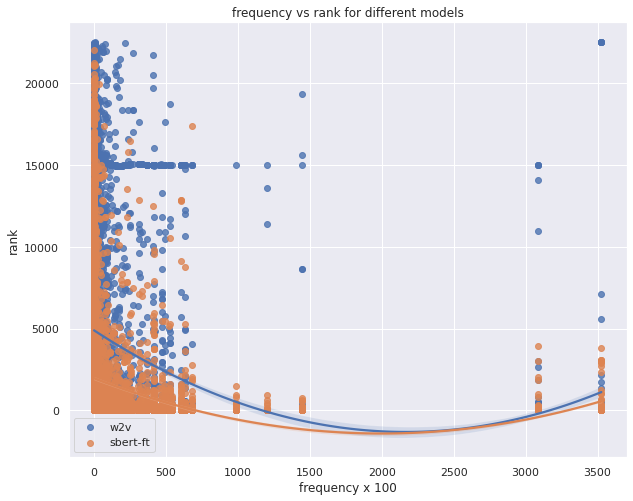

In [18]:
plt.figure(figsize=(10,8))
plot_rank_freq(twitter_w2v_negsample_ranks, twitter_ys, twitter_cntr, 'w2v', order=2)
plot_rank_freq(twitter_sbertft_ranks, twitter_ys, twitter_cntr, 'sbert-ft', order=2)
plt.legend()
plt.show()

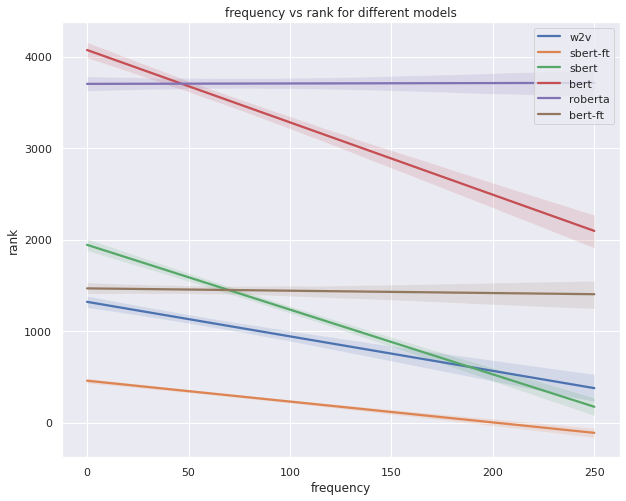

In [74]:
plt.figure(figsize=(10,8))
plot_rank_freq(wiki_w2v_cbow_ranks, wiki_ys, wiki_cntr, 'w2v', order=1)
plot_rank_freq(wiki_sbertft_ranks, wiki_ys, wiki_cntr, 'sbert-ft', order=1)
plot_rank_freq(wiki_sbert_ranks, wiki_ys, wiki_cntr, 'sbert')
plot_rank_freq(wiki_bert_ranks, wiki_ys, wiki_cntr, 'bert')
plot_rank_freq(wiki_roberta_ranks, wiki_ys, wiki_cntr, 'roberta')
plot_rank_freq(wiki_bertft_ranks, wiki_ys, wiki_cntr, 'bert-ft')
plt.legend(loc='upper right')
plt.show()

# per sample comparison - top samples

## worst samples of each model

In [30]:
from sentence_transformers import SentenceTransformer, models, util
import pandas as pd

def get_worst_ranks(xs, ys, ranks, other_ranks_dict, name='default', topk=1000):
    if isinstance(ranks[0], list):
        ranks = [r[0] for r in ranks]
    ids = list(range(len(ranks)))
    
    ds_ranks = zip(ids, xs, ys, ranks)
    sorted_ds = sorted(ds_ranks, key=lambda x: -x[3])[:topk]
    
    ids, xs, ys, ranks = zip(*sorted_ds)
    
    rank_names = []
    other_ranks_list = []

    for rank_name, other_rank in other_ranks_dict.items():
        rank_names.append(rank_name)
        r = []
        for i in ids:
            r.append(other_rank[i])
        other_ranks_list.append(r)

    other_ranks_dict = {}
    for rank_name, rank in zip(rank_names, other_ranks_list):
        other_ranks_dict[rank_name] = rank
    
    df = pd.DataFrame({
        'bio': xs,
        'target': ys,
        f'{name}_rank': ranks,
        **other_ranks_dict
    })
    
    df.to_csv(f'{name}.csv', index=False, header=True)
    
    return ranks
    
    
    
all_ranks = {
    'w2v': [r[0] for r in twitter_w2v_negsample_ranks],
    'bert-ft': [r[0] for r in twitter_bertft_ranks],
    'sbert-ft': [r[0] for r in twitter_sbert_ranks],
    'bert': [r[0] for r in twitter_bert_ranks]
}

xs, ys = zip(*fixed_target_twitter_clm_ds)
get_worst_ranks(xs, ys, twitter_w2v_negsample_ranks,
                other_ranks_dict= {k:v for k,v in all_ranks.items() if k != 'w2v'},
                name='w2v')
get_worst_ranks(xs, ys, twitter_bertft_ranks,
                other_ranks_dict= {k:v for k,v in all_ranks.items() if k != 'bert-ft'},
                name='bert-ft')
get_worst_ranks(xs, ys, twitter_bert_ranks,
                other_ranks_dict= {k:v for k,v in all_ranks.items() if k != 'bert'},
                name='bert')
_ = get_worst_ranks(xs, ys, twitter_sbertft_ranks,
                other_ranks_dict= {k:v for k,v in all_ranks.items() if k != 'sbert-ft'},
                name='sbert-ft')



## nearest neighbors of samples analysis

In [52]:
%%time
import torch
from sentence_transformers import SentenceTransformer, models, util
from tqdm import tqdm
from torch.nn.functional import log_softmax



def normalize(word_vectors):
    norms = torch.norm(word_vectors, dim=1, keepdim=True)
    res = word_vectors / (norms + 1e-6)
    return res

def calculate_nearest_neighbors(model, tokenizer, pi, pi_dict,
                                default_encoder=False, device='cuda:0', w2v=False, average_k_layers=3,
                                cosine_bs=512, emb_bs=512, topk=10):
    pi_list = list(pi_dict.keys())
    
    if w2v:
        emb_x = torch.tensor([model.wv.get_mean_vector([pi,])], device=device)
        emb_all = torch.tensor([model.wv.get_vector(x) for x in pi_list], device=device)
    elif default_encoder:        
        emb_x = get_sbertbased_results_batched(model, [pi,], bs=emb_bs)
        emb_all = get_sbertbased_results_batched(model, pi_list, bs=emb_bs)
    else:
        emb_x = get_results_batched(model, tokenizer, [pi,], average_k_layers=average_k_layers, bs=emb_bs)
        emb_all = get_results_batched(model, tokenizer, pi_list, average_k_layers=average_k_layers, bs=emb_bs)

    emb_x = normalize(emb_x)
    emb_all = normalize(emb_all)
    
    
    batch_cosine_scores = util.cos_sim(emb_x.to(device), emb_all.to(device))
    ranks = torch.argsort(torch.argsort(batch_cosine_scores, dim=1, descending=True), dim=1).tolist()[0]
    batch_cosine_scores = batch_cosine_scores.tolist()[0]
    res = sorted(list(zip(pi_list, ranks, batch_cosine_scores)), key=lambda x: x[1])[1:]
    
    return res[:topk]



CPU times: user 24 µs, sys: 0 ns, total: 24 µs
Wall time: 28.6 µs


512it [00:00, 26725.95it/s]          
22528it [00:10, 2174.10it/s]                           
512it [00:00, 26626.54it/s]          
22528it [00:10, 2124.38it/s]                           


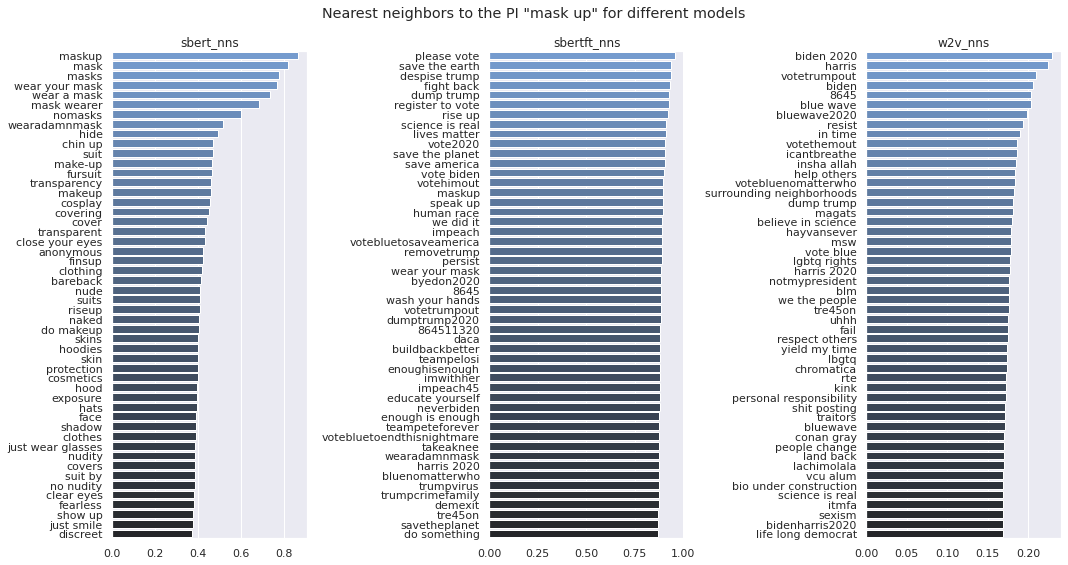

In [54]:
import matplotlib.pyplot as plt
import seaborn as sns



def visualize_nns(pi, topk=30):
    assert pi in w2v_twitter_negsamp_model.wv.key_to_index
    #TODO: change the pi dict
    models = {
        'sbert_nns': calculate_nearest_neighbors(
            model=sbert_model,
            tokenizer=None,
            pi=pi,
            pi_dict=twitter_target_restricted_pis,
            default_encoder=True,
            topk=topk
        ),

        'sbertft_nns': calculate_nearest_neighbors(
            model=twitter_ft_sbert,
            tokenizer=None,
            pi=pi,
            pi_dict=twitter_target_restricted_pis,
            default_encoder=True,
            topk=topk
        ),


        'w2v_nns': calculate_nearest_neighbors(
            model=w2v_twitter_negsamp_model,
            tokenizer=None,
            pi=pi,
            pi_dict=twitter_target_restricted_pis,
            w2v=True,
            topk=topk
        )
    }
    
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 8))
    fig.suptitle(f'Nearest neighbors to the PI "{pi}" for different models')

    cplt = sns.dark_palette("#69d", topk, reverse=True)

    for i , (model_name, nns) in enumerate(models.items()):
    
        nns = sorted(nns, key=lambda x: x[1])
        sns.barplot(
            ax=axes[i],
            x=[x[2] for x in nns],
            y=[x[0] for x in nns],
            palette=np.array(cplt)[[x[1]-1 for x in nns]],
        ).set(title=model_name)


    fig.tight_layout()
    plt.show()
    
visualize_nns("mask up", topk=50)


## load best rankings for w2v and fine-tuned model on twitter

In [ ]:
from sentence_transformers import SentenceTransformer, models, util

def get_topk_ranks(w2v_model, x, y ,pi_dict, device='cpu', k=50):
    pi_list = list(pi_dict.keys())
    inv_dict = {v:k for k,v in pi_dict.items()}
    
    emb_x = torch.tensor([w2v_model.wv.get_mean_vector(x),], device=device)
    emb_all = torch.tensor([w2v_model.wv.get_vector(x) for x in pi_list], device=device)
    
    i = 0

    cosine_scores = util.cos_sim(emb_x, emb_all)
    ranks = torch.argsort(cosine_scores, dim=1, descending=True)
    rankranks = torch.argsort(ranks, dim=1)
    
    top_idxs = ranks[0,:k].tolist()
    top_pis = [inv_dict[i] for i in top_idxs]
    target_idx = torch.tensor([pi_dict[y]], dtype=torch.int64)
    target_rank = torch.gather(rankranks, 1, target_idx.unsqueeze(1).reshape(-1,1)).type(torch.FloatTensor).tolist()[0][0]

    return target_rank, top_pis



get_topk_ranks(
    w2v_twitter_negsamp_model,
    x=['dsd', 'xxxxxx', 'sd;flskdf;'],
    y='maga',
    pi_dict=twitter_pi_dict,
)


In [ ]:
random_ids = np.random.randint(0, len(fixed_target_twitter_clm_ds), 100)

sample = [fixed_target_twitter_clm_ds[i] for i in random_ids]

for i, s in zip(random_ids, sample):
    r_w2v, _ = get_topk_ranks(
        w2v_twitter_negsamp_model,
        x=s[0],
        y=s[1],
        pi_dict=twitter_target_restricted_pis,
        wv=True
    )
    
    r_sbertft, _ = get_topk_ranks(
        twitter_ft_sbert,
        x=s[0],
        y=s[1],
        pi_dict=twitter_target_restricted_pis,
        wv=False
    )
    
    if r_sbertft > r_w2v + 1000:
        print(f"index:{i} w2vscore:{r_w2v}  sbert_ft score:{r_sbertft}")
        print("*"*100)
        print(s[0], "--->", s[1])
        print("*"*100)
    
    

In [ ]:
from numpy.linalg import norm as np_norm
import matplotlib.pyplot as plt
    
    
bertft100_dists = []
sbertft100_dists = []
sbert_dists = []
w2v_dists = []
bert_dists = []


def diff_norm(x1, x2):
    x1n = x1 / np_norm(x1)
    x2n = x2 / np_norm(x2)
    return np_norm(x1n-x2n)

for i in range(1, 4):
    sbert_dists.append(diff_norm(sbert_model.encode(f'mother of {i}'), sbert_model.encode('christian')))
    
    bert_emb = get_results_batched(bert_model, bert_tokenizer, [f'mother of {i}', 'christian']).numpy()
    bert_dists.append(diff_norm(bert_emb[0], bert_emb[1]))
    
    sbertft100_dists.append(diff_norm(twitter_ft_sbert.encode(f'mother of {i}'), twitter_ft_sbert.encode('christian')))
    
    bert_emb = get_results_batched(bert_ft_twitter_model, bert_tokenizer, [f'mother of {i}', 'christian']).numpy()
    bertft100_dists.append(diff_norm(bert_emb[0], bert_emb[1]))

    w2v_dists.append(diff_norm(w2v_twitter_negsamp_model.wv.get_mean_vector([f'mother of {i}']), w2v_twitter_negsamp_model.wv.get_vector('christian')))




xs = [f'mother of {i}' for i in range(1,4)]
sns.lineplot(x=xs, y=w2v_dists, label='w2v')
sns.lineplot(x=xs, y=bert_dists, label='bert')
sns.lineplot(x=xs, y=sbert_dists, label='sbert')
sns.lineplot(x=xs, y=bertft100_dists, label='fine-tuned bert')
sns.lineplot(x=xs, y=sbertft100_dists, label='fine-tuned sbert')
plt.ylabel("L2 distance to <christian>")
plt.xticks(rotation=80)

In [ ]:
from numpy.linalg import norm as np_norm
import matplotlib.pyplot as plt
    
    
bertft100_dists = []
sbertft100_dists = []
sbert_dists = []
w2v_dists = []
bert_dists = []


def diff_norm(x1, x2):
    x1n = x1 / np_norm(x1)
    x2n = x2 / np_norm(x2)
    return np_norm(x1n-x2n)

for i in range(1, 4):
    sbert_dists.append(diff_norm(sbert_model.encode(f'mother of {i}'), sbert_model.encode('christian')))
    
    bert_emb = get_results_batched(bert_model, bert_tokenizer, [f'mother of {i}', 'christian']).numpy()
    bert_dists.append(diff_norm(bert_emb[0], bert_emb[1]))
    
    sbertft100_dists.append(diff_norm(wiki_ft_sbert.encode(f'mother of {i}'), wiki_ft_sbert.encode('christian')))
    
    bert_emb = get_results_batched(bert_ft_wiki_model, bert_tokenizer, [f'mother of {i}', 'christian']).numpy()
    bertft100_dists.append(diff_norm(bert_emb[0], bert_emb[1]))

    w2v_dists.append(diff_norm(w2v_wiki_cbow_model.wv.get_mean_vector([f'mother of {i}']), w2v_wiki_cbow_model.wv.get_vector('christian')))

xs = [f'mother of {i}' for i in range(1,4)]
sns.lineplot(x=xs, y=w2v_dists, label='w2v')
sns.lineplot(x=xs, y=bert_dists, label='bert')
sns.lineplot(x=xs, y=sbert_dists, label='sbert')
sns.lineplot(x=xs, y=bertft100_dists, label='fine-tuned bert')
sns.lineplot(x=xs, y=sbertft100_dists, label='fine-tuned sbert')
plt.ylabel("L2 distance to <christian>")
plt.xticks(rotation=80)

# build survey questions

## neighborhood score + negative sampling choices

In [ ]:
import pandas as pd
from ast import literal_eval

df = pd.read_csv('twitter_pi_with_neighbors_tfidf.csv')
print(df.head())
df.positives = df.positives.apply(literal_eval)
df.negatives = df.negatives.apply(literal_eval)

In [ ]:
from tqdm import tqdm
from random import randint

pis = df['pis']
positives = df['positives']
negatives = df['negatives']

sample_cnt = 500
questions = []
targets = []
other_choices = []

sample_idices = np.random.randint(0, len(df), size=sample_cnt)

for qid in sample_idices:
    q = pis[qid]
    cur_pos = positives[qid]
    cur_neg = negatives[qid]
    target = cur_pos[randint(0,len(cur_pos)-1)]
    targets.append(target)
    questions.append(q)
    other_choices.append(np.random.choice(cur_neg, size=3, replace=False))
    
res = pd.DataFrame({'question_pi': questions, 'ans_pi': targets, 'other_choices': other_choices})
res.to_csv('surrvey_tfidf_twitter.csv', index=False, header=True)

In [ ]:
!head surrvey_tfidf_twitter.csv -n 100

## model based question generation

In [ ]:
from sentence_transformers import SentenceTransformer, models, util

fint_model = SentenceTransformer('./models/miniLM-L6-finetuned/')

In [ ]:
from tqdm import tqdm
from random import randint


all_pis = df['pis']
sims = df['similars']
sample_cnt = 500

questions = []
targets = []
other_choices = []

i = 0
while i < sample_cnt:
    idx = randint(0, len(all_pis)-1)
    questions.append(all_pis[idx])
    i += 1



In [ ]:
fint_emb_x = fint_model.encode(questions, convert_to_tensor=True)
fint_emb_all = fint_model.encode(all_pis, convert_to_tensor=True)


In [ ]:
import numpy as np

targets = []
other_choices = []

for x in tqdm(fint_emb_x):
    cosine_scores = util.cos_sim(x, fint_emb_all).detach().cpu().numpy()[0]
    argsort = np.argsort(cosine_scores)
    best_k = argsort[-6:-1]
    worst_k = argsort[:len(argsort)//2]
    
    target_idx = np.random.choice(best_k)
    targets.append(all_pis[target_idx])
    
    other_idxs = np.random.choice(worst_k, size=3, replace=False)
    other_choices.append([all_pis[x] for x in other_idxs])
    
    
res = pd.DataFrame({'question_pi': questions, 'ans_pi': targets, 'other_choices': other_choices})
res.to_csv('modelbased-selection.csv', index=False, header=True)
    

In [ ]:
!head modelbased-selection.csv